## Logistic Regression
This notebook runs the drug repurposing project's first model, logistic regression. Run all 50 assays, first part would be creating the predictive logistic regression for each assay, and save feature coefficients. We'll use the statistic logistic regression model to look at specific uncommon features' p-value/std error

### Predictive models

In [1]:
import random
import math

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler,LabelBinarizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay

import pymc as pm
import aesara.tensor as T
import arviz as az


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [24]:
xls = pd.ExcelFile('assay_list.xls')

# Now you can list all sheets in the file
xls.sheet_names

# to read just one sheet to dataframe:
df = []
for i in range(len(xls.sheet_names)):
    df1 = xls.parse(i)
    df.append(df1)

len(df)


34

In [25]:
xls2 = pd.ExcelFile('assay_list2.xls')

for i in range(len(xls2.sheet_names)):
    df1 = xls2.parse(i)
    df.append(df1)

len(df)



50

In [5]:
df[1]

Unnamed: 0  tox21-ap1-agonist-p1  \
0              0                     1   
1              1                     0   
2              2                     0   
3              3                     0   
4              4                     0   
...          ...                   ...   
9052        9206                     0   
9053        9207                     0   
9054        9208                     0   
9055        9209                     0   
9056        9210                     0   

                                          SMILES  MaxEStateIndex  \
0                [Br-].CCCCCCCCCCCCCC[n+]1ccccc1        2.287998   
1                 C[C@]12CC[C@H](C[C@H]1O)C2(C)C        9.814236   
2                CCC2=CN(c1ccccc1)C(CCC)C(=C2)CC        2.473380   
3                                   OCC(=O)OCCCC       10.214402   
4                            Nc1ccc(cc1)C(=O)OCC       11.092937   
...                                          ...             ...   
9052  CC/C(=N\OC\C=C\Cl)C1=C(O)CC(CC(C)SCC)CC1=O       12.447525   
9053                            Oc1cc2ccccc2cc1O        9.167281   
9054              CCN(CC)c1ccc(cc1)/N=N/c2ccccc2        4.235067   
9055                   O=C(c1ccc(Cl)cc1)c2ccccc2       11.914512   
9056        c5ccc6c1cc2cccc3ccc4ccc(c1c4c23)c6c5        2.374444   

      MinEStateIndex  MaxAbsEStateIndex  MinAbsEStateIndex       qed    MolWt  \
0           0.000000           2.287998           0.000000  0.377974  356.392   
1          -0.031250           9.814236           0.031250  0.566800  154.253   
2           0.534907           2.473380           0.534907  0.689255  255.405   
3          -0.538472          10.214402           0.426481  0.442392  132.159   
4          -0.307870          11.092937           0.307870  0.532618  165.192   
...              ...                ...                ...       ...      ...   
9052       -0.037469          12.447525           0.037469  0.363123  359.919   
9053       -0.075278           9.167281           0.075278  0.580080  160.172   
9054        0.870666           4.235067           0.870666  0.692852  253.349   
9055        0.020617          11.914512           0.020617  0.701803  216.667   
9056        1.337645           2.374444           1.337645  0.288335  276.338   

      HeavyAtomMolWt  ...  fr_sulfide  fr_sulfonamd  fr_sulfone  \
0            322.120  ...           0             0           0   
1            136.109  ...           0             0           0   
2            230.205  ...           0             0           0   
3            120.063  ...           0             0           0   
4            154.104  ...           0             0           0   
...              ...  ...         ...           ...         ...   
9052         333.711  ...           1             0           0   
9053         152.108  ...           0             0           0   
9054         234.197  ...           0             0           0   
9055         207.595  ...           0             0           0   
9056         264.242  ...           0             0           0   

      fr_term_acetylene  fr_tetrazole  fr_thiazole  fr_thiocyan  fr_thiophene  \
0                     0             0            0            0             0   
1                     0             0            0            0             0   
2                     0             0            0            0             0   
3                     0             0            0            0             0   
4                     0             0            0            0             0   
...                 ...           ...          ...          ...           ...   
9052                  0             0            0            0             0   
9053                  0             0            0            0             0   
9054                  0             0            0            0             0   
9055                  0             0            0            0             0   
9056           

In [6]:
df[0].iloc[:,1].value_counts()

0    8952
1     732
Name: tox21-ahr-p1, dtype: int64

### Run single assay model with L2 penalty

In [76]:
label_encoder = preprocessing.LabelEncoder()
RANDOM_SEED = 101
np.random.seed(RANDOM_SEED)
one_assay = df[0]
print(len(one_assay))
one_assay = one_assay.drop(one_assay.columns[0],axis=1).drop_duplicates()
print(len(one_assay.columns))
scaler = StandardScaler().fit(one_assay.iloc[:,2:])
X = scaler.transform(one_assay.iloc[:,2:])
y = label_encoder.fit_transform(one_assay.iloc[:,0])
indices = range(7713)
X_train, X_test, y_train, y_test, indice_train, indice_test = train_test_split(X, y, indices, test_size=0.20, shuffle=True)
pd.DataFrame(indice_train).to_csv('train_index.csv', index=False)
print(len(X_train))
print(len(indice_train))

9684
206
6170
6170


In [77]:
#one_assay.to_csv('one_assay.csv', index=False)
one_assay

tox21-ahr-p1                                             SMILES  \
0                1                    [Br-].CCCCCCCCCCCCCC[n+]1ccccc1   
1                0                     C[C@]12CC[C@H](C[C@H]1O)C2(C)C   
2                0                    CCC2=CN(c1ccccc1)C(CCC)C(=C2)CC   
3                0                                       OCC(=O)OCCCC   
4                0                                Nc1ccc(cc1)C(=O)OCC   
...            ...                                                ...   
9677             0                         Clc1ccc(OCC(O)COC(N)=O)cc1   
9679             0  O=S(=O)(O)O.C[C@@H](CC)CCCCC(=O)N[C@@H](CCN)C(...   
9680             0                          Cl.O=S(N)(=O)c1ccc(CN)cc1   
9681             0  Oc1cc(cc(O)c1)C(O)CNC(C)C.O=S(=O)(O)O.CC(C)NCC...   
9682             0  [Na+].[O-]C(=O)CCC(=O)OCC(=O)[C@@]4(O)CC[C@@H]...   

      MaxEStateIndex  MinEStateIndex  MaxAbsEStateIndex  MinAbsEStateIndex  \
0           2.287998        0.000000           2.287998           0.000000   
1           9.814236       -0.031250           9.814236           0.031250   
2           2.473380        0.534907           2.473380           0.534907   
3          10.214402       -0.538472          10.214402           0.426481   
4          11.092937       -0.307870          11.092937           0.307870   
...              ...             ...                ...                ...   
9677       10.248885       -0.925423          10.248885           0.008842   
9679       14.424310       -4.666667          14.424310           0.013058   
9680       10.779027       -3.568620          10.779027           0.000000   
9681        9.733565       -4.666667           9.733565           0.047595   
9682       13.079510       -1.724403          13.079510           0.000000   

           qed     MolWt  HeavyAtomMolWt   ExactMolWt  ...  fr_sulfide  \
0     0.377974   356.392         322.120   355.187462  ...           0   
1     0.566800   154.253         136.109   154.135765  ...           0   
2     0.689255   255.405         230.205   255.198700  ...           0   
3     0.442392   132.159         120.063   132.078644  ...           0   
4     0.532618   165.192         154.104   165.078979  ...           0   
...        ...       ...             ...          ...  ...         ...   
9677  0.816060   245.662         233.566   245.045486  ...           0   
9679  0.024478  1267.561        1164.745  1266.732957  ...           0   
9680  0.750448   222.697         211.609   222.022976  ...           0   
9681  0.224312   520.601         484.313   520.209066  ...           0   
9682  0.321723   484.521         451.257   484.207312  ...           0   

      fr_sulfonamd  fr_sulfone  fr_term_acetylene  fr_tetrazole  fr_thiazole  \
0                0           0                  0             0            0   
1                0           0                  0             0            0   
2                0           0                  0             0            0   
3                0           0                  0             0            0   
4                0           0                  0             0            0   
...            ...         ...                ...           ...          ...   
9677             0           0                  0             0            0   
9679             0           0                  0             0            0   
9680             1           0                  0             0            0   
9681             0           0                  0             0            0   
9682             0           0                  0             0            0   

      fr_thiocyan  fr_thiophene  fr_unbrch_alkane  fr_urea  
0               0             0                10        0  
1               0             0                 0        0  
2               0             0                 0        0  
3               0             0                 1        0  
4               0             0      

In [78]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(array([0, 1]), array([5661,  509]))
(array([0, 1]), array([1418,  125]))


In [83]:
from sklearn.linear_model import Lasso
# logistic_cv_unbalanced = LogisticRegressionCV(penalty='l1',Cs=10,max_iter=10000,class_weight=None, solver = 'saga').fit(X_train, y_train)
# logistic_cv_balanced = LogisticRegressionCV(penalty='l1',Cs=10,max_iter=10000,class_weight='balanced', solver = 'saga').fit(X_train, y_train)
logistic_cv_unbalanced = LogisticRegressionCV(penalty='l1',class_weight=None, solver = 'saga').fit(X_train, y_train)
logistic_cv_balanced = LogisticRegressionCV(penalty='l1',class_weight='balanced', solver = 'saga').fit(X_train, y_train)


/opt/anaconda3/envs/pymc_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/pymc_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/pymc_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/pymc_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/pymc_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/pymc_env/lib/python3

/opt/anaconda3/envs/pymc_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/pymc_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/pymc_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/pymc_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/pymc_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/pymc_env/lib/python3

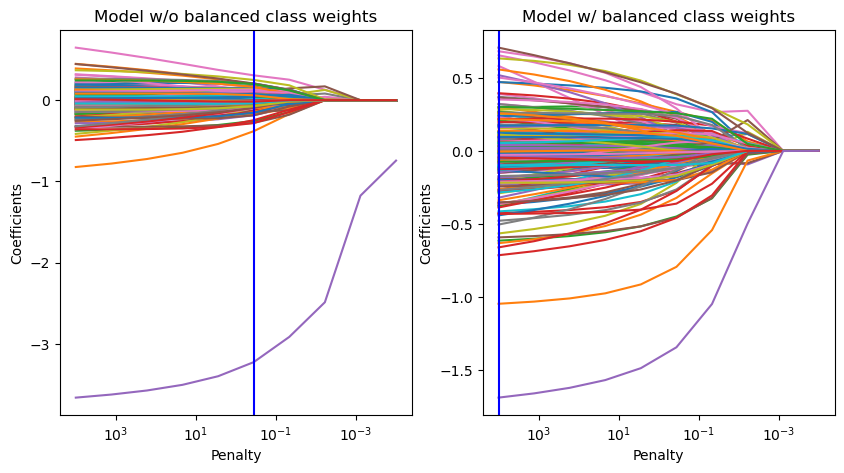

In [84]:
fig, (ax, ax1) = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

ax.plot(logistic_cv_unbalanced.Cs_, logistic_cv_unbalanced.coefs_paths_[1].mean(axis=0))
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
ax.axvline(x =logistic_cv_unbalanced.C_, color = 'b', label = 'axvline - full height')
ax.set_xlabel("Penalty")
ax.set_ylabel("Coefficients")
ax.set_title("Model w/o balanced class weights")

ax1.plot(logistic_cv_balanced.Cs_, logistic_cv_balanced.coefs_paths_[1].mean(axis=0))
ax1.set_xscale("log")
ax1.set_xlim(ax1.get_xlim()[::-1])  # reverse axis
ax1.axvline(x =logistic_cv_balanced.C_, color = 'b', label = 'axvline - full height')
ax1.set_xlabel("Penalty")
ax1.set_ylabel("Coefficients")
ax1.set_title("Model w/ balanced class weights")


plt.show()

In [85]:
y_pred_unbalanced = logistic_cv_unbalanced.predict(X_test)
y_pred_balanced = logistic_cv_balanced.predict(X_test)

In [86]:
print("Unbalanced model report")
print(classification_report(y_test,y_pred_unbalanced))

Unbalanced model report
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      1418
           1       0.52      0.22      0.31       125

    accuracy                           0.92      1543
   macro avg       0.73      0.60      0.63      1543
weighted avg       0.90      0.92      0.90      1543



In [87]:
print("Balanced model report")
print(classification_report(y_test,y_pred_balanced))

Balanced model report
              precision    recall  f1-score   support

           0       0.98      0.80      0.88      1418
           1       0.26      0.77      0.38       125

    accuracy                           0.80      1543
   macro avg       0.62      0.79      0.63      1543
weighted avg       0.92      0.80      0.84      1543



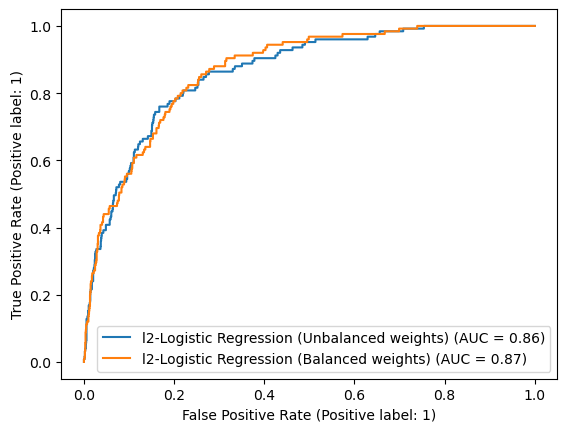

In [88]:
ax = plt.gca()

RocCurveDisplay.from_estimator(logistic_cv_unbalanced, X_test, y_test,ax=ax,name="l2-Logistic Regression (Unbalanced weights)")
RocCurveDisplay.from_estimator(logistic_cv_balanced, X_test, y_test,ax=ax,name="l2-Logistic Regression (Balanced weights)")

plt.show()

In [89]:
from sklearn import metrics
y_pred_prob = logistic_cv_unbalanced.predict_proba(X_test)[:,1]
y_pred_prob_bal = logistic_cv_balanced.predict_proba(X_test)[:,1]

metrics.roc_auc_score(y_test, y_pred_prob)

0.8640507757404796

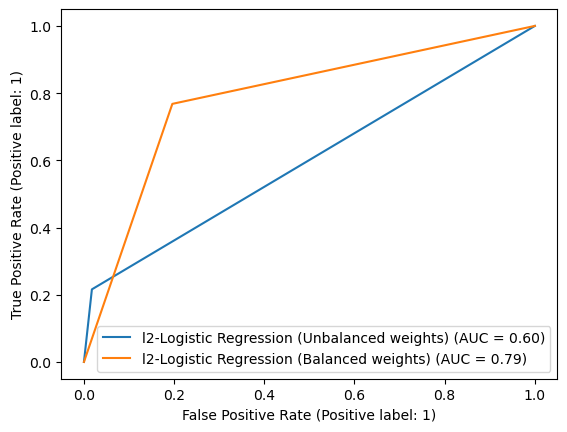

In [90]:
ax = plt.gca()

RocCurveDisplay.from_predictions(y_test, y_pred_unbalanced, ax=ax,name="l2-Logistic Regression (Unbalanced weights)")
RocCurveDisplay.from_predictions(y_test, y_pred_balanced, ax=ax,name="l2-Logistic Regression (Balanced weights)")

plt.show()

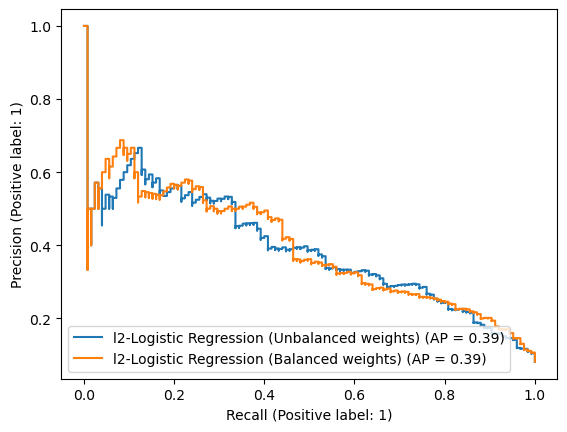

In [91]:
ax = plt.gca()

PrecisionRecallDisplay.from_estimator(logistic_cv_unbalanced, X_test, y_test,ax=ax,name="l2-Logistic Regression (Unbalanced weights)")
PrecisionRecallDisplay.from_estimator(logistic_cv_balanced, X_test, y_test,ax=ax,name="l2-Logistic Regression (Balanced weights)")

plt.show()

In [92]:
print(logistic_cv_unbalanced.Cs_)
# len(logistic_cv_unbalanced.coefs_paths_[1].mean(axis=0))
len(logistic_cv_unbalanced.coef_[0])

[1.00000000e-04 7.74263683e-04 5.99484250e-03 4.64158883e-02
 3.59381366e-01 2.78255940e+00 2.15443469e+01 1.66810054e+02
 1.29154967e+03 1.00000000e+04]


204

In [94]:
coef_u = logistic_cv_balanced.coef_[0]
pd.DataFrame({'features': list(one_assay.columns[2:]), 'coefs': list(coef_u)}, columns=['features', 'coefs'])

features     coefs
0       MaxEStateIndex  0.077774
1       MinEStateIndex -0.247424
2    MaxAbsEStateIndex  0.108520
3    MinAbsEStateIndex  0.057078
4                  qed -0.223599
..                 ...       ...
199        fr_thiazole -0.094106
200        fr_thiocyan  0.104176
201       fr_thiophene  0.131187
202   fr_unbrch_alkane  0.292755
203            fr_urea -0.034994

[204 rows x 2 columns]

### Run all 50 assays

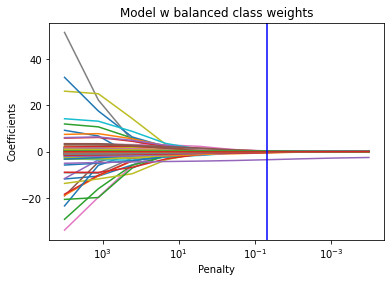

SMILES
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      1421
           1       0.62      0.24      0.34       122

    accuracy                           0.93      1543
   macro avg       0.78      0.61      0.65      1543
weighted avg       0.91      0.93      0.91      1543



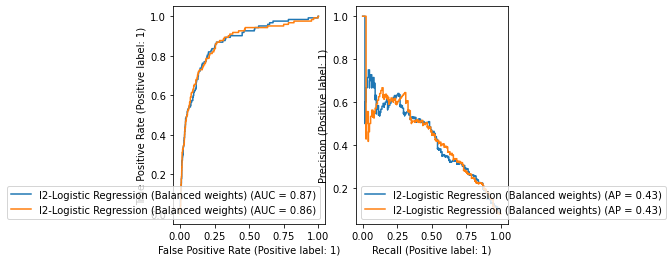

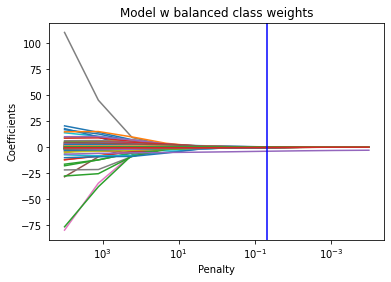

SMILES
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1392
           1       0.60      0.17      0.26        89

    accuracy                           0.94      1481
   macro avg       0.77      0.58      0.62      1481
weighted avg       0.93      0.94      0.93      1481



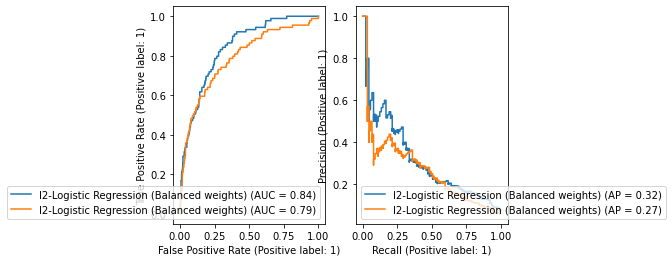

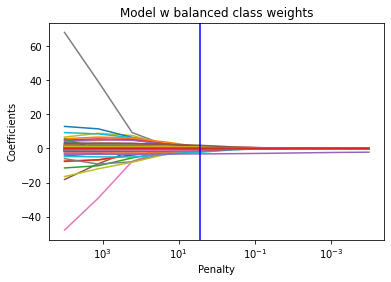

SMILES
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1384
           1       0.46      0.24      0.32       143

    accuracy                           0.90      1527
   macro avg       0.69      0.61      0.63      1527
weighted avg       0.88      0.90      0.89      1527



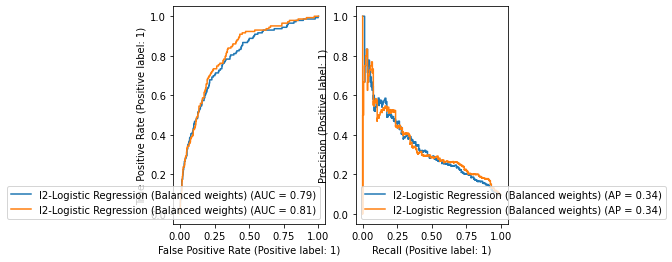

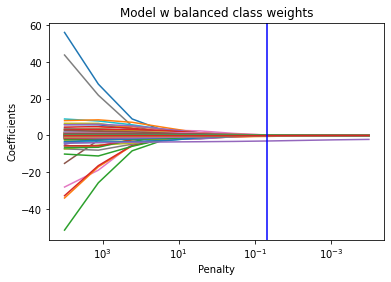

SMILES
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1322
           1       0.61      0.28      0.38       162

    accuracy                           0.90      1484
   macro avg       0.76      0.63      0.66      1484
weighted avg       0.88      0.90      0.88      1484



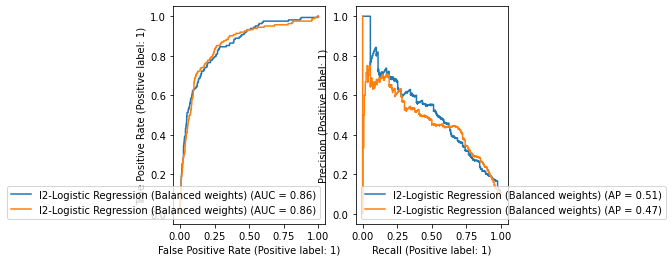

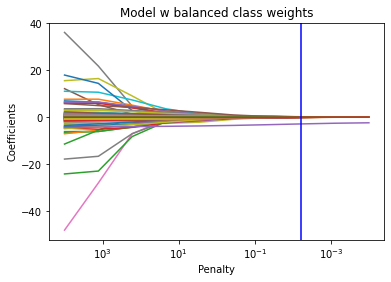

SMILES
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1450
           1       0.53      0.18      0.27       127

    accuracy                           0.92      1577
   macro avg       0.73      0.58      0.61      1577
weighted avg       0.90      0.92      0.90      1577



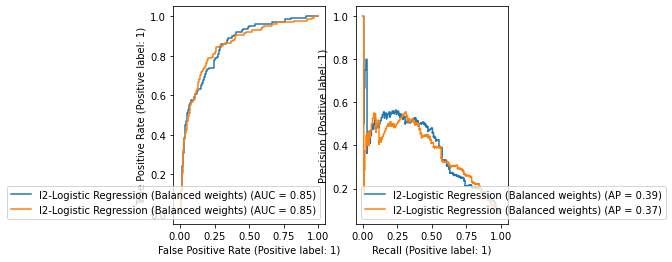

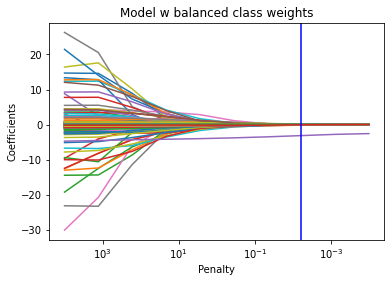

SMILES
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1406
           1       0.74      0.27      0.40       107

    accuracy                           0.94      1513
   macro avg       0.85      0.63      0.68      1513
weighted avg       0.93      0.94      0.93      1513



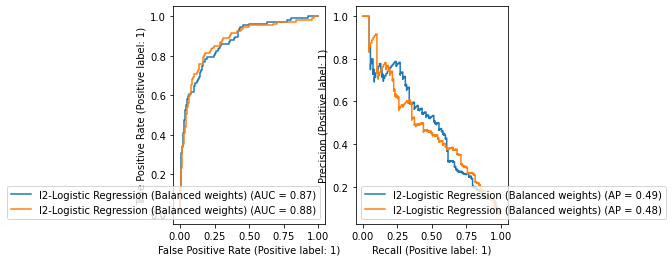

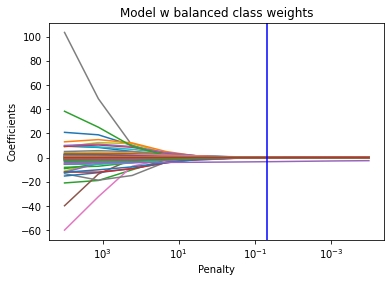

SMILES
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      1285
           1       0.67      0.20      0.31       110

    accuracy                           0.93      1395
   macro avg       0.80      0.60      0.64      1395
weighted avg       0.91      0.93      0.91      1395



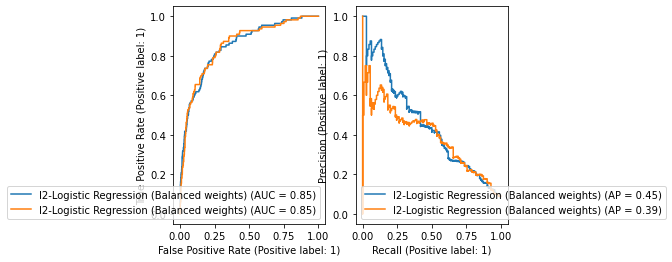

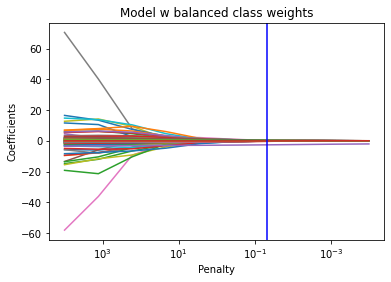

SMILES
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1358
           1       0.49      0.24      0.32       180

    accuracy                           0.88      1538
   macro avg       0.70      0.60      0.63      1538
weighted avg       0.86      0.88      0.86      1538



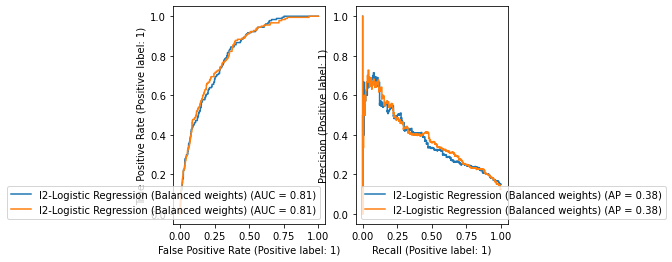

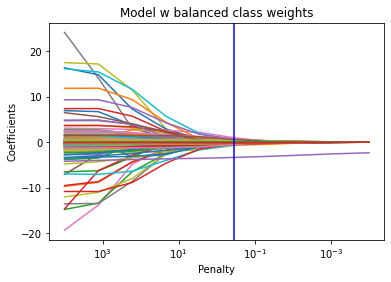

SMILES
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1360
           1       0.62      0.29      0.39       126

    accuracy                           0.92      1486
   macro avg       0.78      0.63      0.68      1486
weighted avg       0.91      0.92      0.91      1486



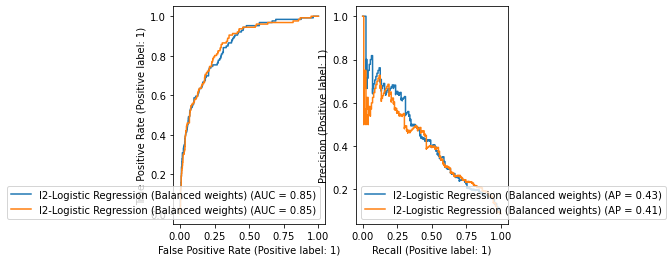

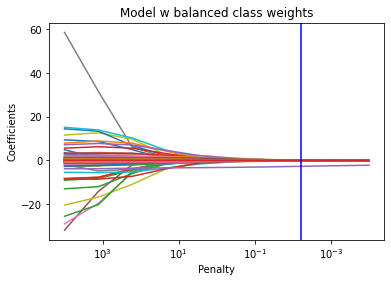

SMILES
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1333
           1       0.76      0.20      0.32       160

    accuracy                           0.91      1493
   macro avg       0.84      0.60      0.63      1493
weighted avg       0.90      0.91      0.88      1493



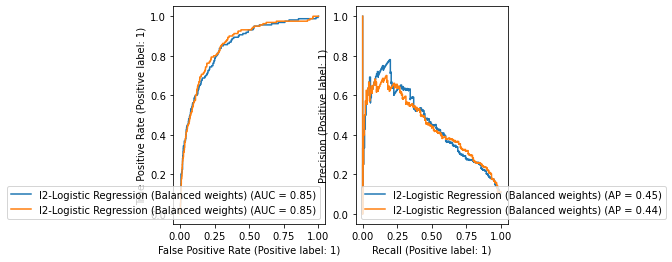

/opt/anaconda3/envs/pymc_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


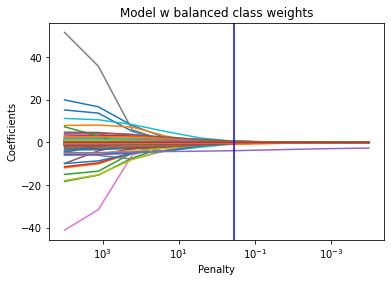

SMILES
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1443
           1       0.41      0.15      0.22       113

    accuracy                           0.92      1556
   macro avg       0.68      0.57      0.59      1556
weighted avg       0.90      0.92      0.91      1556



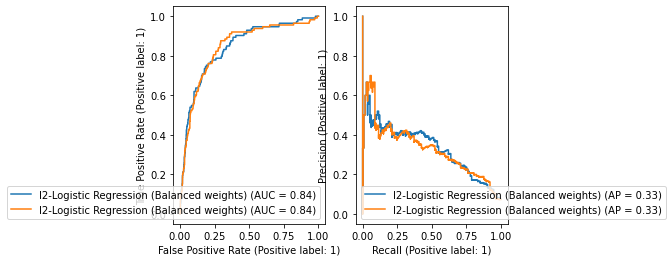

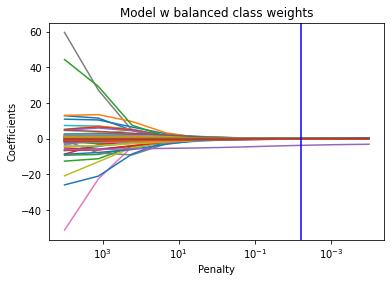

SMILES
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1475
           1       0.50      0.05      0.09        77

    accuracy                           0.95      1552
   macro avg       0.73      0.52      0.53      1552
weighted avg       0.93      0.95      0.93      1552



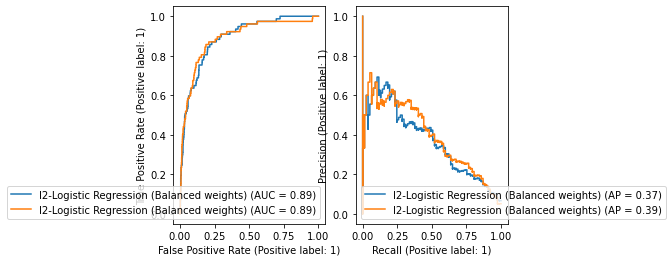

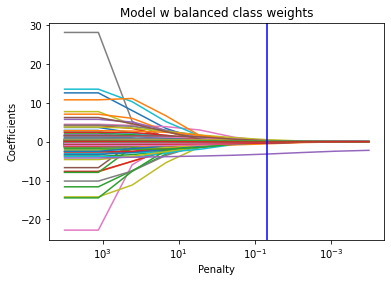

SMILES
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      1307
           1       0.72      0.37      0.48       153

    accuracy                           0.92      1460
   macro avg       0.82      0.67      0.72      1460
weighted avg       0.91      0.92      0.91      1460



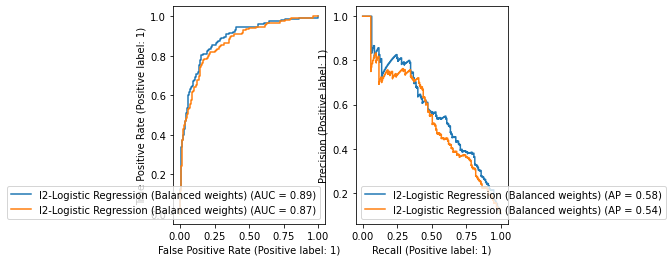

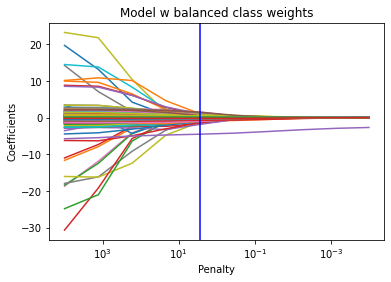

SMILES
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1429
           1       0.63      0.27      0.38       113

    accuracy                           0.94      1542
   macro avg       0.79      0.63      0.67      1542
weighted avg       0.92      0.94      0.92      1542



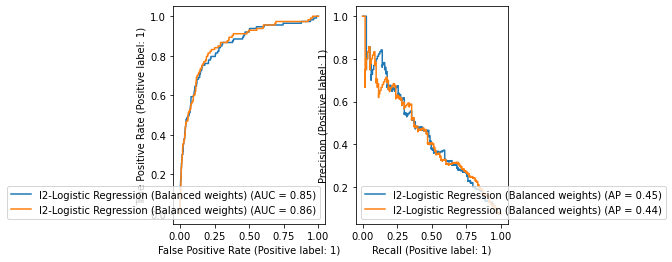

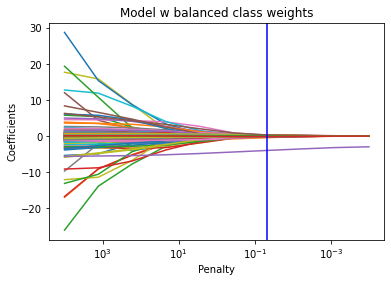

SMILES
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1430
           1       0.64      0.24      0.35        66

    accuracy                           0.96      1496
   macro avg       0.80      0.62      0.67      1496
weighted avg       0.95      0.96      0.95      1496



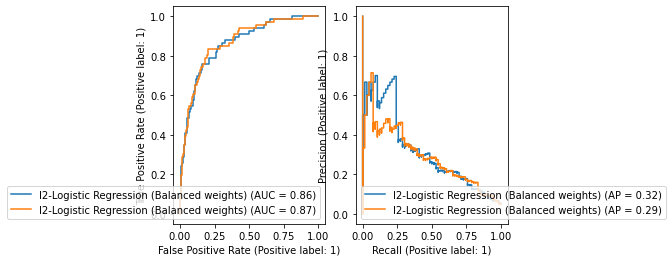

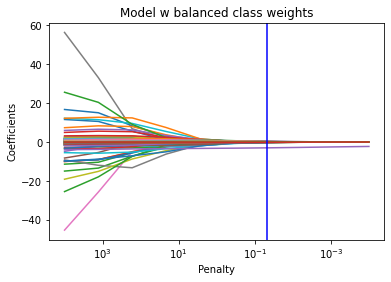

SMILES
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1307
           1       0.64      0.25      0.36       156

    accuracy                           0.90      1463
   macro avg       0.78      0.62      0.65      1463
weighted avg       0.89      0.90      0.89      1463



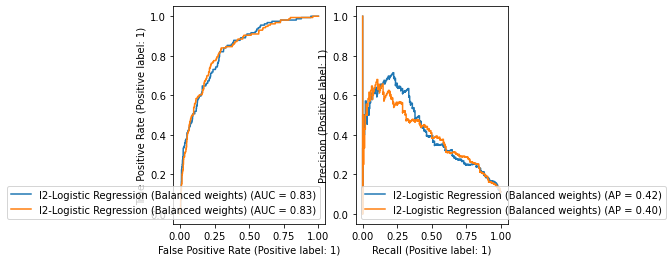

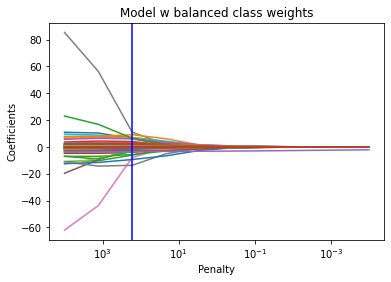

SMILES
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1230
           1       0.56      0.29      0.38       165

    accuracy                           0.89      1395
   macro avg       0.73      0.63      0.66      1395
weighted avg       0.87      0.89      0.87      1395



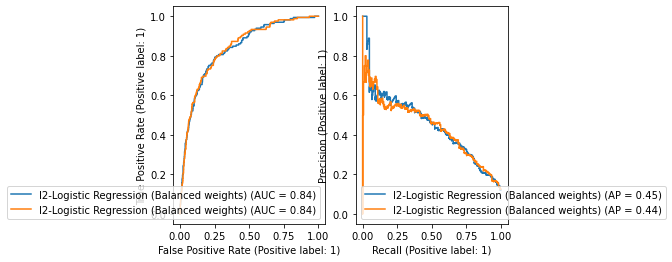

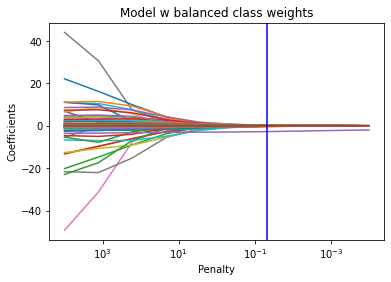

SMILES
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1265
           1       0.56      0.35      0.44       175

    accuracy                           0.89      1440
   macro avg       0.74      0.66      0.69      1440
weighted avg       0.87      0.89      0.88      1440



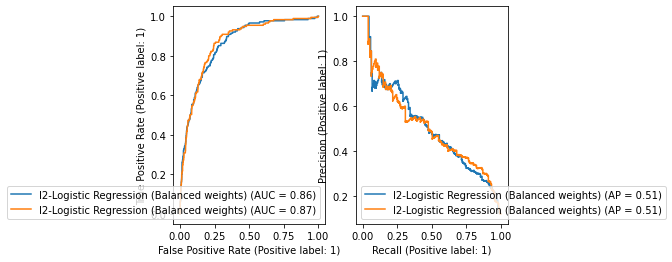

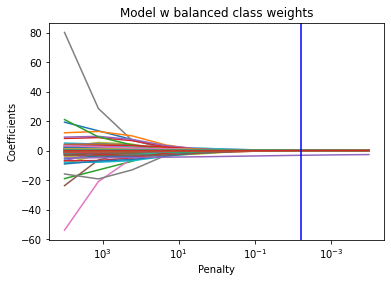

SMILES
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1278
           1       0.73      0.10      0.18        79

    accuracy                           0.95      1357
   macro avg       0.84      0.55      0.57      1357
weighted avg       0.93      0.95      0.93      1357



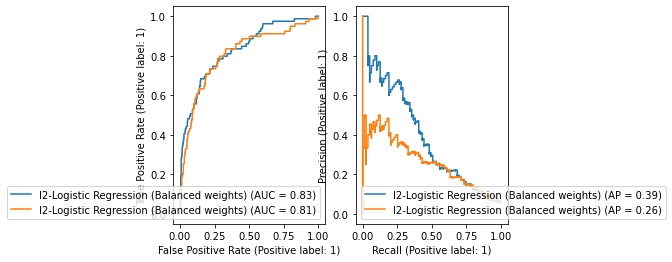

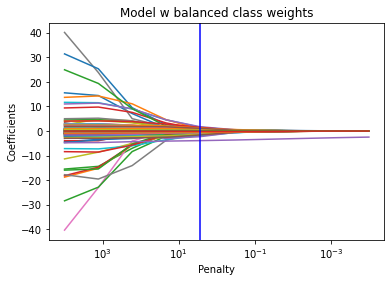

SMILES
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      1178
           1       0.71      0.35      0.47       115

    accuracy                           0.93      1293
   macro avg       0.83      0.67      0.72      1293
weighted avg       0.92      0.93      0.92      1293



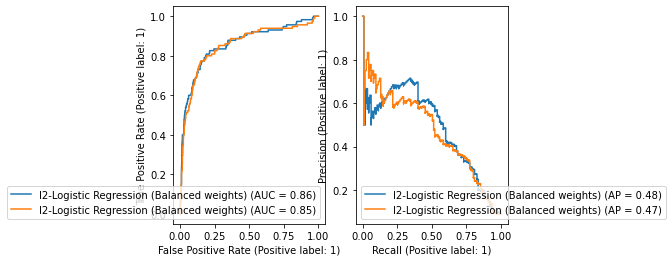

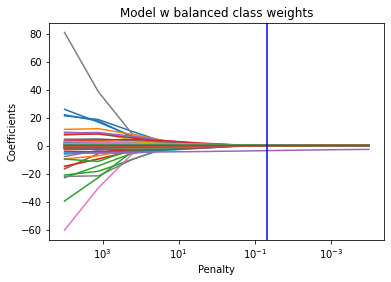

SMILES
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      1244
           1       0.52      0.18      0.27        93

    accuracy                           0.93      1337
   macro avg       0.73      0.58      0.62      1337
weighted avg       0.91      0.93      0.92      1337



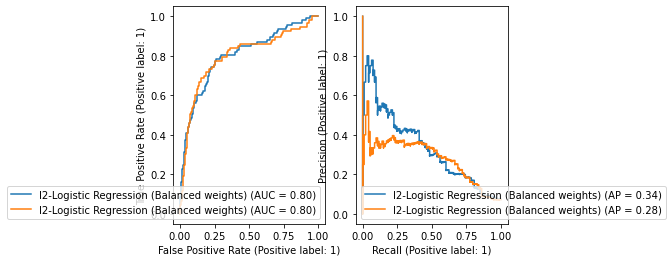

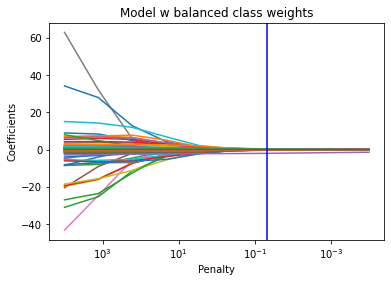

SMILES
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      1136
           1       0.68      0.44      0.53       279

    accuracy                           0.85      1415
   macro avg       0.77      0.69      0.72      1415
weighted avg       0.83      0.85      0.84      1415



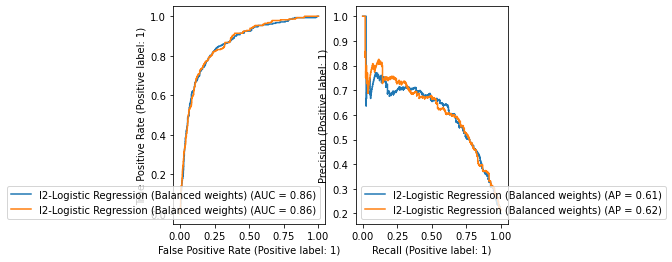

/opt/anaconda3/envs/pymc_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/pymc_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

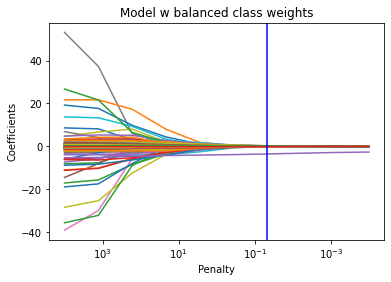

SMILES
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1404
           1       0.60      0.16      0.25        96

    accuracy                           0.94      1500
   macro avg       0.77      0.57      0.61      1500
weighted avg       0.92      0.94      0.92      1500



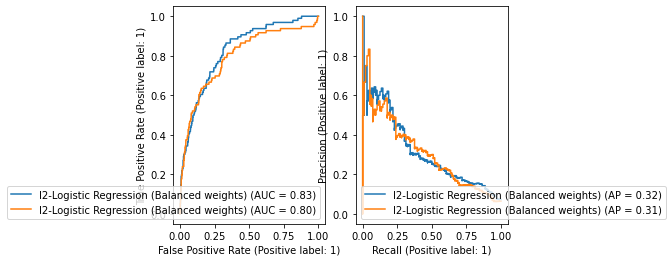

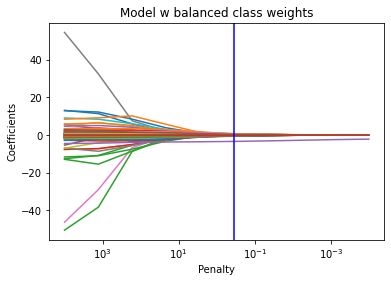

SMILES
              precision    recall  f1-score   support

           0       0.90      0.98      0.93      1263
           1       0.61      0.24      0.34       189

    accuracy                           0.88      1452
   macro avg       0.75      0.61      0.64      1452
weighted avg       0.86      0.88      0.86      1452



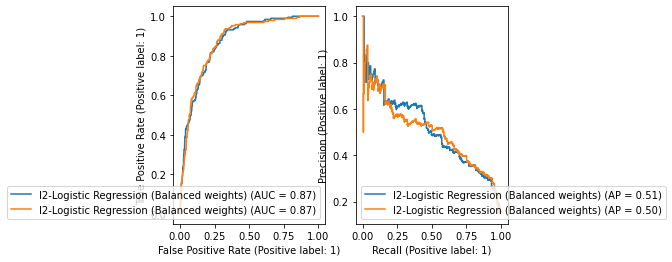

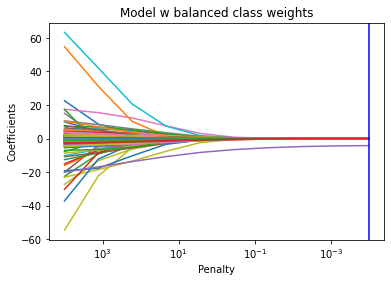

SMILES
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1488
           1       0.00      0.00      0.00        30

    accuracy                           0.98      1518
   macro avg       0.49      0.50      0.50      1518
weighted avg       0.96      0.98      0.97      1518



/opt/anaconda3/envs/pymc_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/pymc_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/pymc_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


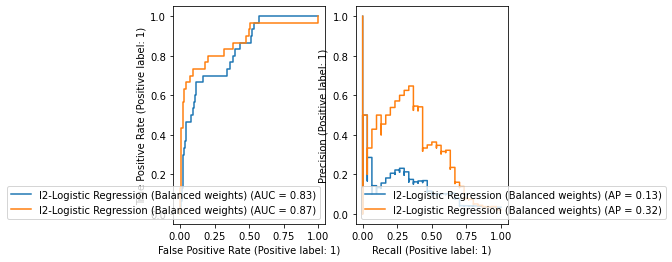

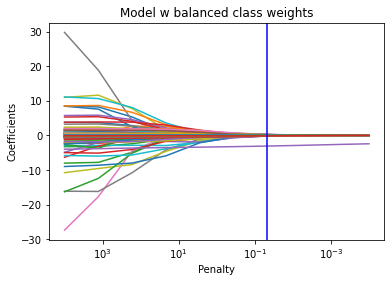

SMILES
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1312
           1       0.43      0.15      0.23       130

    accuracy                           0.90      1442
   macro avg       0.67      0.57      0.59      1442
weighted avg       0.88      0.90      0.88      1442



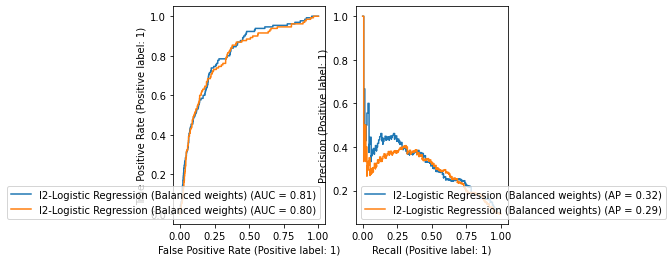

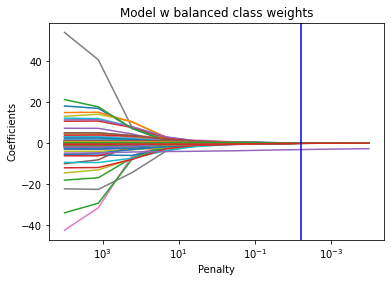

SMILES
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1232
           1       0.62      0.11      0.18        76

    accuracy                           0.94      1308
   macro avg       0.78      0.55      0.58      1308
weighted avg       0.93      0.94      0.93      1308



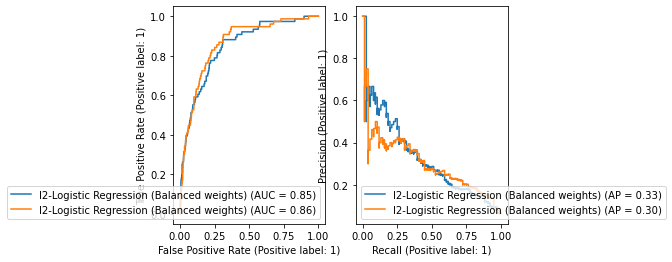

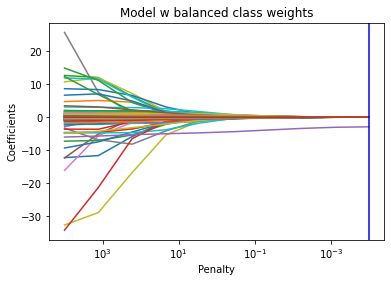

SMILES
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1493
           1       0.00      0.00      0.00        78

    accuracy                           0.95      1571
   macro avg       0.48      0.50      0.49      1571
weighted avg       0.90      0.95      0.93      1571



/opt/anaconda3/envs/pymc_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/pymc_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/pymc_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


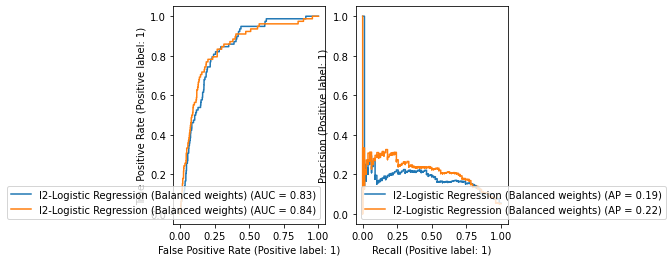

/opt/anaconda3/envs/pymc_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


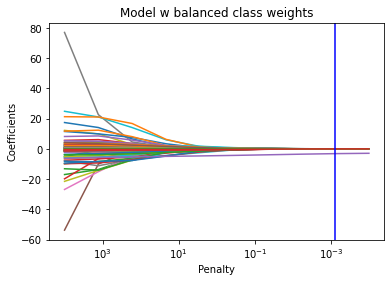

SMILES
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1254
           1       0.33      0.01      0.03        77

    accuracy                           0.94      1331
   macro avg       0.64      0.51      0.50      1331
weighted avg       0.91      0.94      0.92      1331



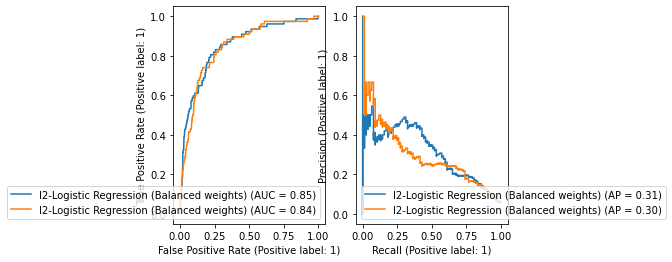

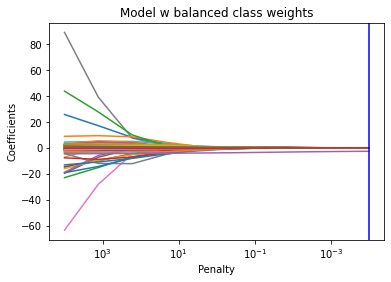

SMILES
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1456
           1       0.00      0.00      0.00       112

    accuracy                           0.93      1568
   macro avg       0.46      0.50      0.48      1568
weighted avg       0.86      0.93      0.89      1568



/opt/anaconda3/envs/pymc_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/pymc_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/pymc_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


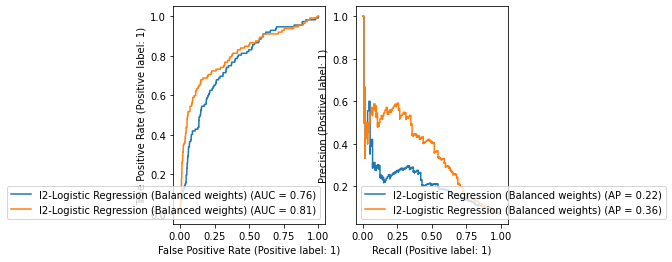

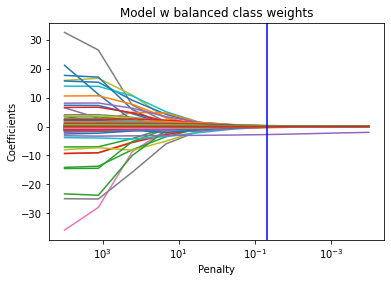

SMILES
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1276
           1       0.60      0.30      0.40       173

    accuracy                           0.89      1449
   macro avg       0.75      0.64      0.67      1449
weighted avg       0.87      0.89      0.88      1449



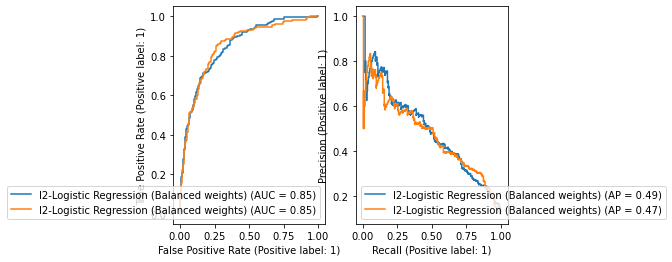

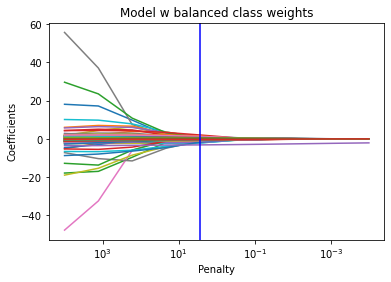

SMILES
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1183
           1       0.65      0.33      0.44       167

    accuracy                           0.89      1350
   macro avg       0.78      0.65      0.69      1350
weighted avg       0.88      0.89      0.88      1350



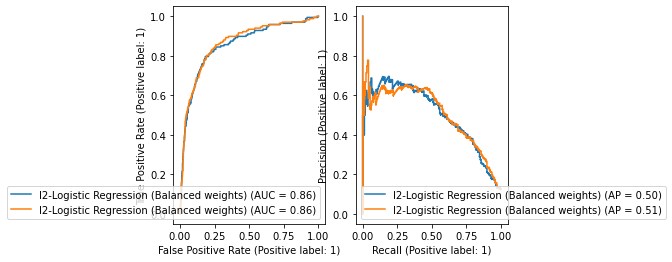

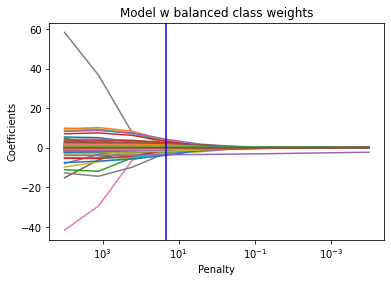

SMILES
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1149
           1       0.53      0.25      0.34       126

    accuracy                           0.90      1275
   macro avg       0.72      0.61      0.64      1275
weighted avg       0.88      0.90      0.89      1275



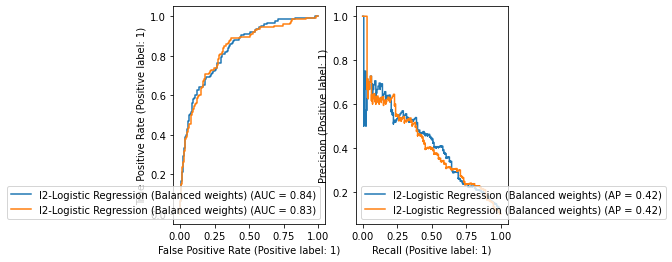

/opt/anaconda3/envs/pymc_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


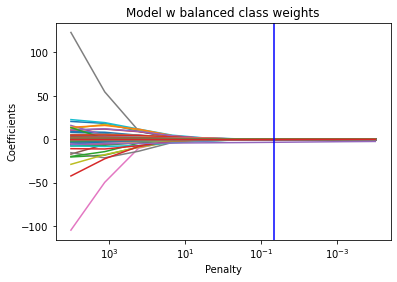

SMILES
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      1156
           1       0.67      0.21      0.31        97

    accuracy                           0.93      1253
   macro avg       0.80      0.60      0.64      1253
weighted avg       0.92      0.93      0.91      1253



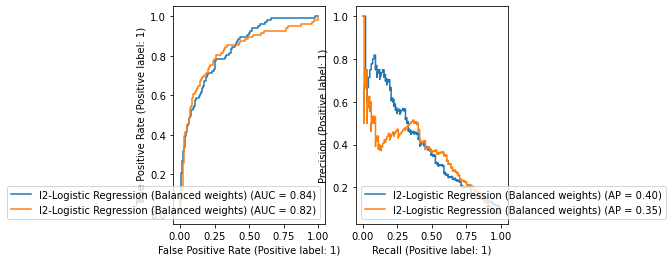

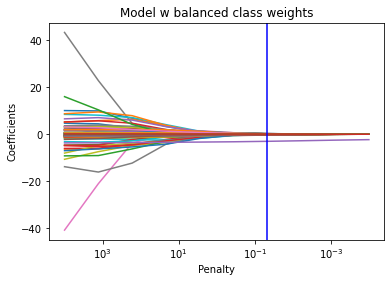

SMILES
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1156
           1       0.56      0.25      0.35       114

    accuracy                           0.91      1270
   macro avg       0.74      0.62      0.65      1270
weighted avg       0.90      0.91      0.90      1270



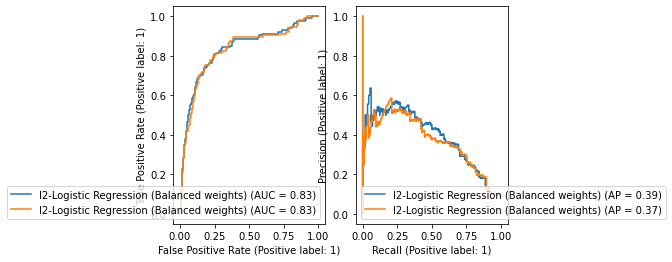

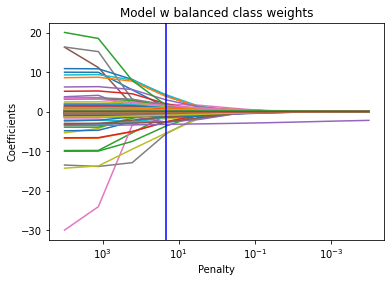

SMILES
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      1263
           1       0.48      0.24      0.32       131

    accuracy                           0.90      1394
   macro avg       0.70      0.61      0.63      1394
weighted avg       0.88      0.90      0.89      1394



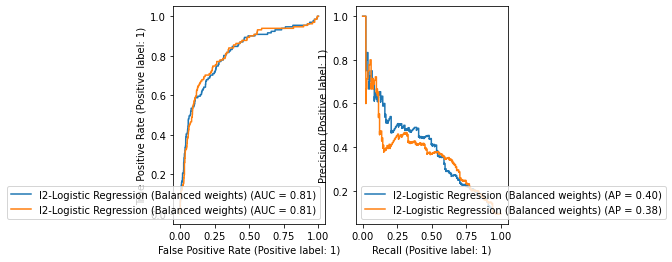

/opt/anaconda3/envs/pymc_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/pymc_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

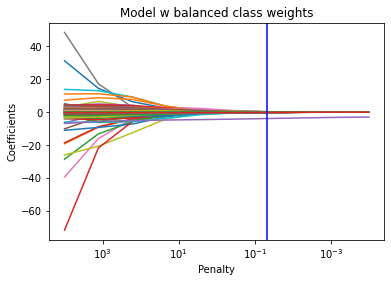

SMILES
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1407
           1       0.59      0.13      0.21        78

    accuracy                           0.95      1485
   macro avg       0.77      0.56      0.59      1485
weighted avg       0.93      0.95      0.93      1485



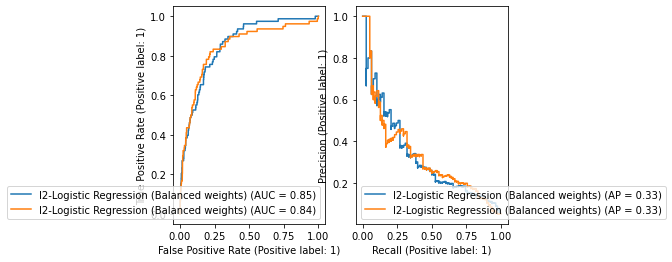

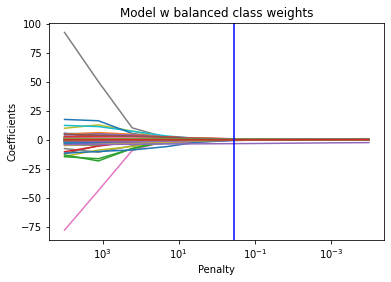

SMILES
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1295
           1       0.61      0.17      0.26       114

    accuracy                           0.92      1409
   macro avg       0.77      0.58      0.61      1409
weighted avg       0.91      0.92      0.90      1409



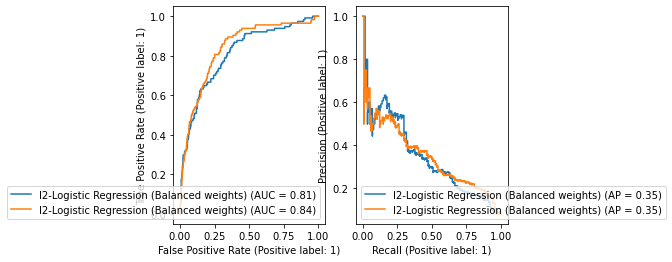

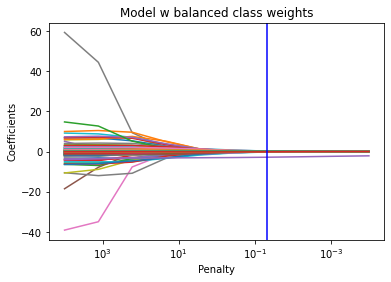

SMILES
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      1230
           1       0.69      0.24      0.35       210

    accuracy                           0.87      1440
   macro avg       0.79      0.61      0.64      1440
weighted avg       0.86      0.87      0.85      1440



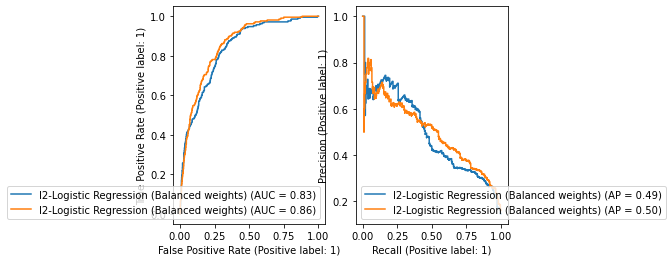

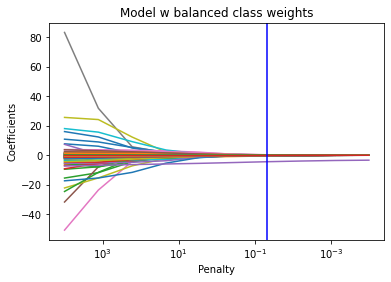

SMILES
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1461
           1       0.40      0.12      0.19        49

    accuracy                           0.97      1510
   macro avg       0.69      0.56      0.58      1510
weighted avg       0.95      0.97      0.96      1510



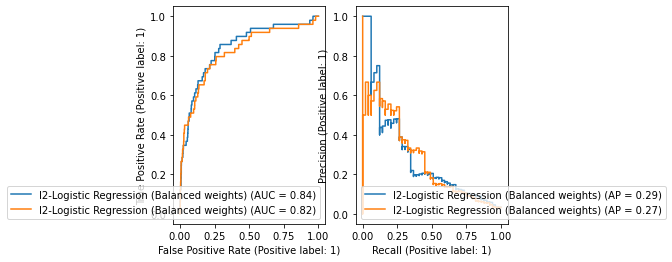

/opt/anaconda3/envs/pymc_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/pymc_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

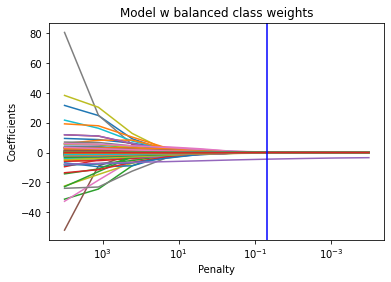

SMILES
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1444
           1       0.80      0.15      0.25        54

    accuracy                           0.97      1498
   macro avg       0.88      0.57      0.62      1498
weighted avg       0.96      0.97      0.96      1498



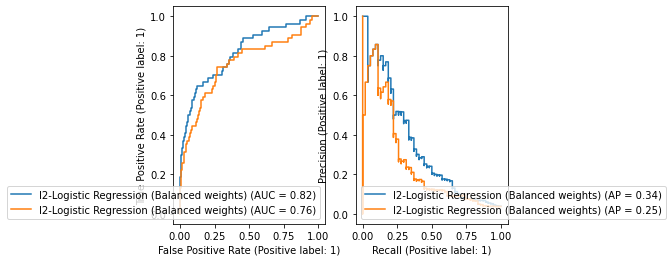

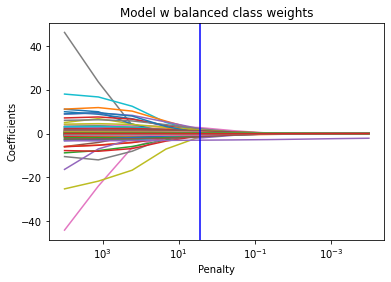

SMILES
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1287
           1       0.66      0.32      0.43       170

    accuracy                           0.90      1457
   macro avg       0.79      0.65      0.69      1457
weighted avg       0.89      0.90      0.89      1457



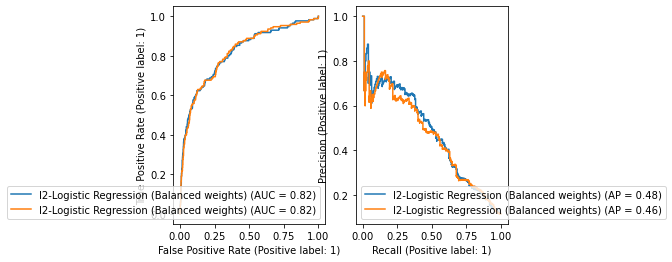

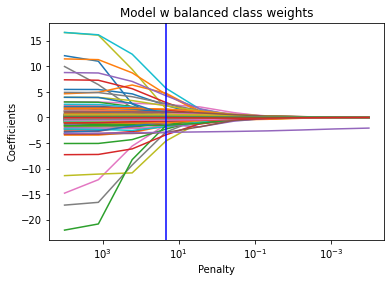

SMILES
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      1276
           1       0.66      0.33      0.44       178

    accuracy                           0.90      1454
   macro avg       0.79      0.65      0.69      1454
weighted avg       0.88      0.90      0.88      1454



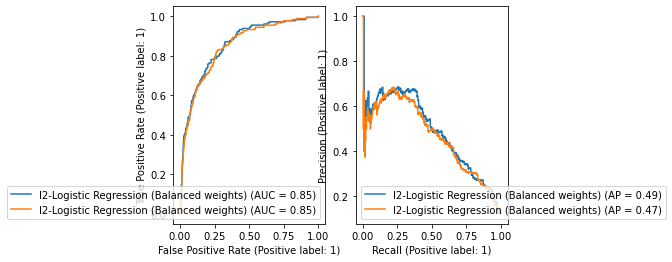

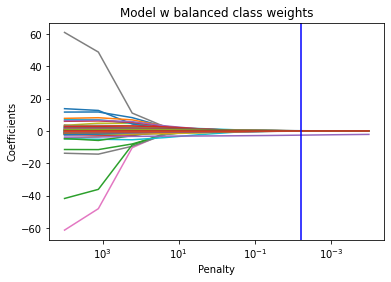

SMILES
              precision    recall  f1-score   support

           0       0.91      0.98      0.95      1230
           1       0.64      0.23      0.34       151

    accuracy                           0.90      1381
   macro avg       0.77      0.61      0.64      1381
weighted avg       0.88      0.90      0.88      1381



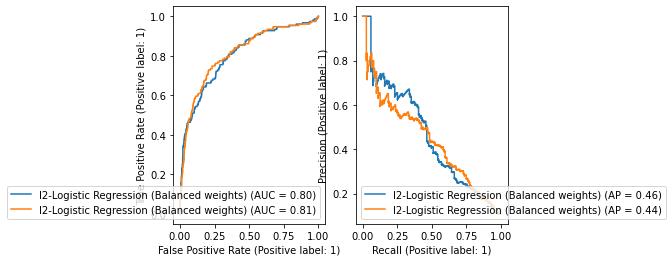

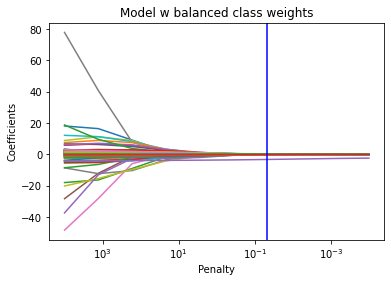

SMILES
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      1156
           1       0.59      0.16      0.25       125

    accuracy                           0.91      1281
   macro avg       0.75      0.57      0.60      1281
weighted avg       0.88      0.91      0.88      1281



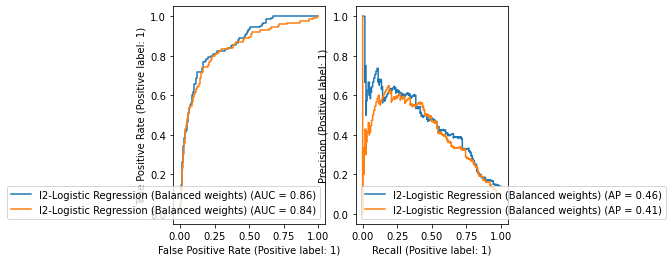

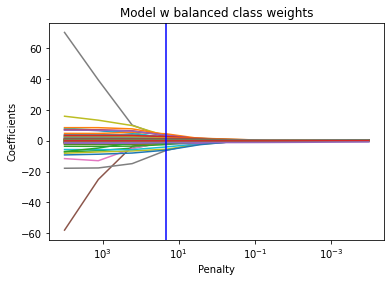

SMILES
              precision    recall  f1-score   support

           0       0.81      0.88      0.85       987
           1       0.70      0.57      0.63       465

    accuracy                           0.78      1452
   macro avg       0.76      0.73      0.74      1452
weighted avg       0.78      0.78      0.78      1452



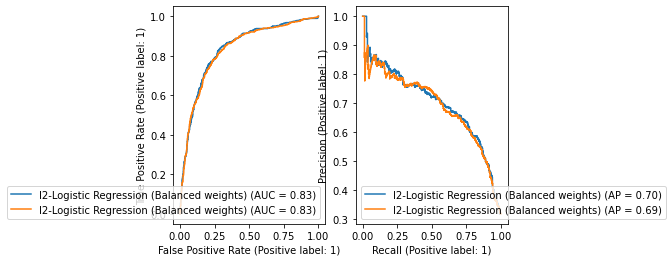

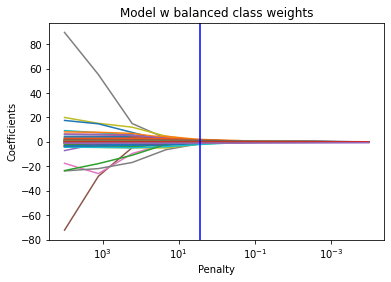

SMILES
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       997
           1       0.69      0.57      0.62       483

    accuracy                           0.77      1480
   macro avg       0.75      0.72      0.73      1480
weighted avg       0.77      0.77      0.77      1480



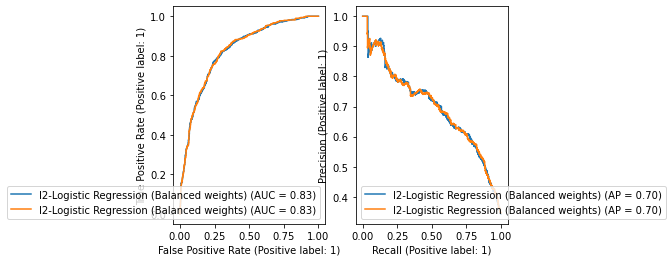

/opt/anaconda3/envs/pymc_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


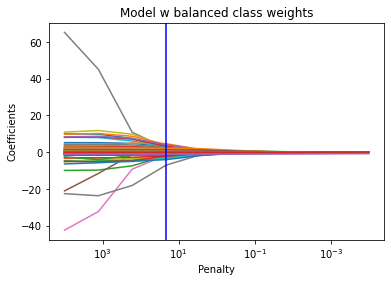

SMILES
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1004
           1       0.66      0.59      0.62       436

    accuracy                           0.78      1440
   macro avg       0.74      0.73      0.73      1440
weighted avg       0.78      0.78      0.78      1440



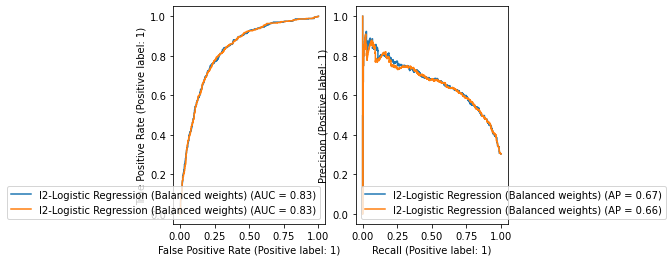

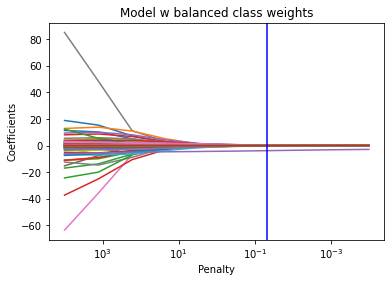

SMILES
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1404
           1       0.57      0.14      0.23        84

    accuracy                           0.95      1488
   macro avg       0.76      0.57      0.60      1488
weighted avg       0.93      0.95      0.93      1488



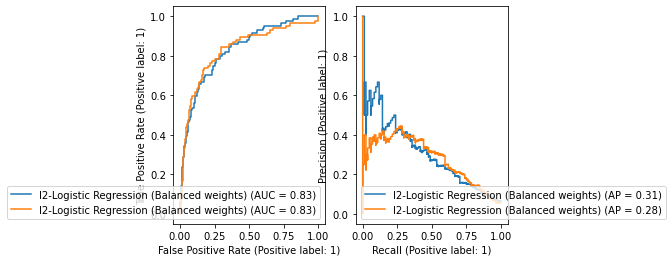

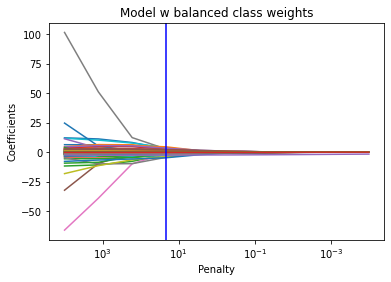

SMILES
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1200
           1       0.63      0.43      0.51       235

    accuracy                           0.86      1435
   macro avg       0.76      0.69      0.71      1435
weighted avg       0.85      0.86      0.85      1435



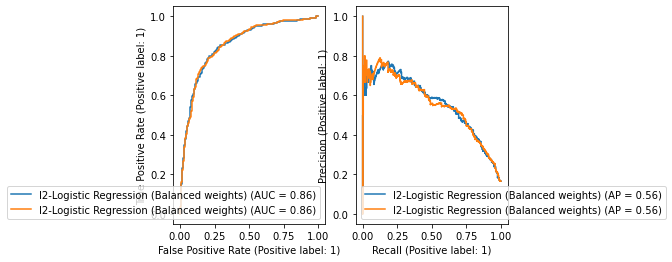

In [20]:
label_encoder = preprocessing.LabelEncoder()
coefs = []
coefs_w = []
bal_accs = []
bal_accs_w = []
auc_scores = []
auc_scores_w = []
lambda_sig_w = []

for i in range(len(df)):
    one_assay = df[i]
    one_assay = one_assay.drop(one_assay.columns[0],axis=1).drop_duplicates()
    scaler = StandardScaler().fit(one_assay.iloc[:,2:])
    X = scaler.transform(one_assay.iloc[:,2:])
    y = label_encoder.fit_transform(one_assay.iloc[:,0])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True)
    logistic_cv_unbalanced = LogisticRegressionCV(penalty='l2',Cs=10,max_iter=10000,class_weight=None).fit(X_train, y_train)
    logistic_cv_balanced = LogisticRegressionCV(penalty='l2',Cs=10,max_iter=10000,class_weight='balanced').fit(X_train, y_train)

    coef = logistic_cv_unbalanced.coef_[0]
    coefs.append(coef)
    
    coef_w = logistic_cv_balanced.coef_[0]
    coefs_w.append(coef_w)
    
    ax = plt.gca()
    fig.set_size_inches(10, 5)

    ax.plot(logistic_cv_unbalanced.Cs_, logistic_cv_unbalanced.coefs_paths_[1].mean(axis=0))
    ax.set_xscale("log")
    ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
    ax.axvline(x =logistic_cv_unbalanced.C_, color = 'b', label = 'axvline - full height')
    ax.set_xlabel("Penalty")
    ax.set_ylabel("Coefficients")
    ax.set_title("Model w balanced class weights")
    plt.show()

    y_pred_unbalanced = logistic_cv_unbalanced.predict(X_test)
    y_pred_balanced = logistic_cv_balanced.predict(X_test)
    
    y_pred_prob = logistic_cv_unbalanced.predict_proba(X_test)[:,1]
    y_pred_prob_bal = logistic_cv_balanced.predict_proba(X_test)[:,1]

    print(one_assay.columns[1])
    print(classification_report(y_test,y_pred_unbalanced))
    
    bal_acc = balanced_accuracy_score(y_test,y_pred_unbalanced)
    bal_accs.append(bal_acc)
    
    bal_acc_w = balanced_accuracy_score(y_test,y_pred_balanced)
    bal_accs_w.append(bal_acc_w)
    
    auc_score = metrics.roc_auc_score(y_test, y_pred_prob)
    auc_scores.append(auc_score)
    
    auc_score_w = metrics.roc_auc_score(y_test, y_pred_prob_bal)
    auc_scores_w.append(auc_score_w)
    
    lambda_sig = logistic_cv_balanced.C_
    lambda_sig_w.append(lambda_sig)

    fig, (ax, ax1) = plt.subplots(1,2)
#     ax = plt.gca()

    RocCurveDisplay.from_estimator(logistic_cv_unbalanced, X_test, y_test,ax=ax,name="l2-Logistic Regression (Balanced weights)")
    RocCurveDisplay.from_estimator(logistic_cv_balanced, X_test, y_test,ax=ax,name="l2-Logistic Regression (Balanced weights)")

#     ax1 = plt.gca()

    PrecisionRecallDisplay.from_estimator(logistic_cv_unbalanced, X_test, y_test,ax=ax1,name="l2-Logistic Regression (Balanced weights)")
    PrecisionRecallDisplay.from_estimator(logistic_cv_balanced, X_test, y_test,ax=ax1,name="l2-Logistic Regression (Balanced weights)")

    plt.show()


### save all coefficients and change columns and rows name

In [48]:
coefs_df = pd.DataFrame(coefs).T
coefs_w_df = pd.DataFrame(coefs_w).T

In [49]:
coefs_df

0         1         2         3         4         5         6   \
0    0.032052  0.117423 -0.011085  5.840383  1.914415  0.017258  0.062885   
1   -0.241282  0.039546 -0.009201 -0.150669 -0.364454 -0.035094  0.162107   
2    0.111496  0.123174 -0.010174 -5.625450 -1.810028  0.018277  0.070346   
3    0.056975 -0.364935 -0.272078 -0.322216 -0.142274 -0.085818 -0.418418   
4   -0.301600 -0.074441 -0.058707 -0.120252 -0.164537 -0.083873 -0.196350   
..        ...       ...       ...       ...       ...       ...       ...   
199  0.026823  0.092604  0.027980  0.100517  0.013967  0.029844  0.027743   
200  0.048808  0.131812  0.071877  0.115144  0.107956  0.058559  0.037423   
201  0.023559 -0.012263  0.044445  0.005577  0.027773  0.023202  0.020665   
202  0.198293  0.131252  0.151840 -0.215000  0.356000  0.079474  0.055508   
203 -0.069739 -0.212674 -0.201761 -0.020938 -0.076893 -0.079367 -0.100631   

           7         8         9   ...        40        41        42  \
0   -0.594326  0.158192  0.075739  ...  0.102955  4.850920  0.795831   
1    0.159343 -0.114239 -0.062649  ... -0.036022 -0.024869 -0.095085   
2    0.773465  0.192252  0.085234  ...  0.093266 -4.774483 -0.611529   
3   -0.428946 -0.220426 -0.230844  ... -0.205229 -0.475228 -0.167755   
4   -0.230770 -0.205263 -0.165403  ... -0.051576 -0.058642 -0.066447   
..        ...       ...       ...  ...       ...       ...       ...   
199 -0.054802  0.071811  0.060565  ...  0.062595 -0.048673  0.051370   
200  0.120199  0.077623  0.090028  ...  0.068725  0.135694  0.114532   
201 -0.157566  0.097610  0.068075  ...  0.021358 -0.043992 -0.072289   
202  0.264297  0.100763  0.031161  ...  0.089245  0.319102  0.117304   
203 -0.072296 -0.125548 -0.091378  ... -0.111661  0.003952 -0.015837   

           43        44        45        46        47        48        49  
0    0.045678  0.063889  6.283479 -0.504767  7.126974 -0.002182  4.264261  
1    0.055112  0.033359  0.211223  0.277648  0.040969  0.000171  0.045571  
2    0.051220  0.069613 -6.239087  0.532123 -7.105165 -0.000366 -3.912444  
3   -0.189518 -0.197163 -0.286861 -0.192576 -0.186928 -0.065104 -0.274898  
4   -0.123661 -0.046744  0.125861  0.166617  0.099666 -0.081054  0.107580  
..        ...       ...       ...       ...       ...       ...       ...  
199  0.003269  0.036905 -0.074971 -0.018944 -0.042908 -0.041554 -0.032176  
200  0.022745  0.108495  0.079262  0.075783  0.039746  0.061192  0.107593  
201 -0.040329 -0.035409 -0.050952  0.054856 -0.050029 -0.029263 -0.042667  
202  0.161846  0.187492  0.092738  0.180391  0.150660  0.037930  0.088958  
203 -0.094213 -0.204886  0.002051 -0.048250 -0.131757 -0.076919 -0.137098  

[204 rows x 50 columns]

In [50]:
fea_name = one_assay.iloc[:,2:].columns
len(fea_name)

204

In [51]:
assay_name = []
for i in range(len(df)):
    one_assay = df[i]
    y = one_assay.columns[1]
    assay_name.append(y)
len(assay_name)

50

In [52]:
coefs_df.columns = assay_name
coefs_df

tox21-ahr-p1  tox21-ap1-agonist-p1  tox21-ar-bla-antagonist-p1  \
0        0.032052              0.117423                   -0.011085   
1       -0.241282              0.039546                   -0.009201   
2        0.111496              0.123174                   -0.010174   
3        0.056975             -0.364935                   -0.272078   
4       -0.301600             -0.074441                   -0.058707   
..            ...                   ...                         ...   
199      0.026823              0.092604                    0.027980   
200      0.048808              0.131812                    0.071877   
201      0.023559             -0.012263                    0.044445   
202      0.198293              0.131252                    0.151840   
203     -0.069739             -0.212674                   -0.201761   

     tox21-ar-mda-kb2-luc-agonist-p3  tox21-ar-mda-kb2-luc-antagonist-p1  \
0                           5.840383                            1.914415   
1                          -0.150669                           -0.364454   
2                          -5.625450                           -1.810028   
3                          -0.322216                           -0.142274   
4                          -0.120252                           -0.164537   
..                               ...                                 ...   
199                         0.100517                            0.013967   
200                         0.115144                            0.107956   
201                         0.005577                            0.027773   
202                        -0.215000                            0.356000   
203                        -0.020938                           -0.076893   

     tox21-ar-mda-kb2-luc-antagonist-p2  tox21-are-bla-p1  tox21-aromatase-p1  \
0                              0.017258          0.062885           -0.594326   
1                             -0.035094          0.162107            0.159343   
2                              0.018277          0.070346            0.773465   
3                             -0.085818         -0.418418           -0.428946   
4                             -0.083873         -0.196350           -0.230770   
..                                  ...               ...                 ...   
199                            0.029844          0.027743           -0.054802   
200                            0.058559          0.037423            0.120199   
201                            0.023202          0.020665           -0.157566   
202                            0.079474          0.055508            0.264297   
203                           -0.079367         -0.100631           -0.072296   

     tox21-car-agonist-p1  tox21-car-antagonist-p1  ...  \
0                0.158192                 0.075739  ...   
1               -0.114239                -0.062649  ...   
2                0.192252                 0.085234  ...   
3               -0.220426                -0.230844  ...   
4               -0.205263                -0.165403  ...   
..                    ...                      ...  ...   
199              0.071811                 0.060565  ...   
200              0.077623                 0.090028  ...   
201              0.097610                 0.068075  ...   
202              0.100763                 0.031161  ...   
203             -0.125548                -0.091378  ...   

     tox21-sbe-bla-antagonist-p1  tox21-shh-3t3-gli3-agonist-p1  \
0                       0.102955                       4.850920   
1                      -0.036022                      -0.024869   
2                       0.093266                      -4.774483   
3                      -0.205229                      -0.475228   
4                      -0.051576                      -0.058642   
..                           ...                            ...   
199                     0.062595                      -0.048673   
200                  

In [53]:
coefs_df.set_axis(fea_name, axis=0)
coefs_df.columns

Index(['tox21-ahr-p1', 'tox21-ap1-agonist-p1', 'tox21-ar-bla-antagonist-p1',
       'tox21-ar-mda-kb2-luc-agonist-p3', 'tox21-ar-mda-kb2-luc-antagonist-p1',
       'tox21-ar-mda-kb2-luc-antagonist-p2', 'tox21-are-bla-p1',
       'tox21-aromatase-p1', 'tox21-car-agonist-p1', 'tox21-car-antagonist-p1',
       'tox21-elg1-luc-agonist-p1', 'tox21-er-bla-antagonist-p1',
       'tox21-er-luc-bg1-4e2-agonist-p4', 'tox21-er-luc-bg1-4e2-antagonist-p1',
       'tox21-er-luc-bg1-4e2-antagonist-p2', 'tox21-erb-bla-antagonist-p1',
       'tox21-erb-bla-p1', 'tox21-err-p1', 'tox21-esre-bla-p1',
       'tox21-fxr-bla-agonist-p2', 'tox21-fxr-bla-antagonist-p1',
       'tox21-gh3-tre-antagonist-p1', 'tox21-gr-hela-bla-antagonist-p1',
       'tox21-h2ax-cho-p2', 'tox21-hdac-p1', 'tox21-hre-bla-agonist-p1',
       'tox21-hse-bla-p1', 'tox21-mitotox-p1', 'tox21-nfkb-bla-agonist-p1',
       'tox21-p53-bla-p1', 'tox21-pgc-err-p1', 'tox21-ppard-bla-agonist-p1',
       'tox21-ppard-bla-antagonist-p1', 'tox21-

In [57]:
coefs_w_df.columns = assay_name
coefs_w_df.set_axis(fea_name, axis=0)

tox21-ahr-p1  tox21-ap1-agonist-p1  \
MaxEStateIndex         1.161765              0.859684   
MinEStateIndex        -0.226538             -0.037015   
MaxAbsEStateIndex     -0.838470             -0.413254   
MinAbsEStateIndex      0.079719             -0.738599   
qed                   -0.303959             -0.233844   
...                         ...                   ...   
fr_thiazole           -0.148351             -0.049881   
fr_thiocyan            0.041334              0.183983   
fr_thiophene          -0.059621             -0.254981   
fr_unbrch_alkane       0.322576              0.102322   
fr_urea               -0.082087             -0.438508   

                   tox21-ar-bla-antagonist-p1  \
MaxEStateIndex                      14.267639   
MinEStateIndex                      -0.049685   
MaxAbsEStateIndex                  -14.139556   
MinAbsEStateIndex                   -0.385337   
qed                                 -0.191509   
...                                       ...   
fr_thiazole                         -0.157433   
fr_thiocyan                          0.069889   
fr_thiophene                        -0.104507   
fr_unbrch_alkane                     0.314440   
fr_urea                             -0.369418   

                   tox21-ar-mda-kb2-luc-agonist-p3  \
MaxEStateIndex                            3.029721   
MinEStateIndex                           -0.142425   
MaxAbsEStateIndex                        -2.617845   
MinAbsEStateIndex                        -0.218495   
qed                                      -0.098215   
...                                            ...   
fr_thiazole                               0.100282   
fr_thiocyan                               0.125841   
fr_thiophene                             -0.002552   
fr_unbrch_alkane                         -0.258040   
fr_urea                                  -0.017764   

                   tox21-ar-mda-kb2-luc-antagonist-p1  \
MaxEStateIndex                               8.910841   
MinEStateIndex                              -0.549701   
MaxAbsEStateIndex                           -8.698580   
MinAbsEStateIndex                           -0.263567   
qed                                         -0.145257   
...                                               ...   
fr_thiazole                                 -0.103416   
fr_thiocyan                                  0.113899   
fr_thiophene                                 0.011325   
fr_unbrch_alkane                             0.343109   
fr_urea                                     -0.205839   

                   tox21-ar-mda-kb2-luc-antagonist-p2  tox21-are-bla-p1  \
MaxEStateIndex                              14.819276         18.911538   
MinEStateIndex                              -0.272307          0.340706   
MaxAbsEStateIndex                          -14.340085        -18.749579   
MinAbsEStateIndex                           -0.495993         -0.504105   
qed                                         -0.237267         -0.336039   
...                                               ...               ...   
fr_thiazole                                 -0.029232         -0.069246   
fr_thiocyan                                  0.082504          0.030036   
fr_thiophene                                -0.016114         -0.044674   
fr_unbrch_alkane                             0.153503         -0.258768   
fr_urea                                     -0.306428         -0.258116   

                   tox21-aromatase-p1  tox21-car-agonist-p1  \
MaxEStateIndex               1.489664              8.691966   
MinEStateIndex              -0.055007              0.017476   
MaxAbsEStateIndex           -1.151752             -8.197568   
MinAbsEStateIndex           -0.355574             -0.257800   
qed                         -0.158945             -0.161273   
...                               ...                   ...   
fr_thiazole                 -0.126163             -0.020969   
fr_thi

In [58]:
coefs_df.set_axis(fea_name, axis=0).to_csv('Unbalanced weight feature coefficients.csv')
coefs_w_df.set_axis(fea_name, axis=0).to_csv('Balanced weight feature coefficients.csv')

In [2]:
# Histogram for feature coefficients
ridge_coef = pd.read_csv('Unbalanced weight feature coefficients.csv')
ridge_coef_w = pd.read_csv('Balanced weight feature coefficients.csv')

ridge_coef

Unnamed: 0  tox21-ahr-p1  tox21-ap1-agonist-p1  \
0       MaxEStateIndex      0.032052              0.117423   
1       MinEStateIndex     -0.241282              0.039546   
2    MaxAbsEStateIndex      0.111496              0.123174   
3    MinAbsEStateIndex      0.056975             -0.364935   
4                  qed     -0.301600             -0.074441   
..                 ...           ...                   ...   
199        fr_thiazole      0.026823              0.092604   
200        fr_thiocyan      0.048808              0.131812   
201       fr_thiophene      0.023559             -0.012263   
202   fr_unbrch_alkane      0.198293              0.131252   
203            fr_urea     -0.069739             -0.212674   

     tox21-ar-bla-antagonist-p1  tox21-ar-mda-kb2-luc-agonist-p3  \
0                     -0.011085                         5.840383   
1                     -0.009201                        -0.150669   
2                     -0.010174                        -5.625450   
3                     -0.272078                        -0.322216   
4                     -0.058707                        -0.120252   
..                          ...                              ...   
199                    0.027980                         0.100517   
200                    0.071877                         0.115144   
201                    0.044445                         0.005577   
202                    0.151840                        -0.215000   
203                   -0.201761                        -0.020938   

     tox21-ar-mda-kb2-luc-antagonist-p1  tox21-ar-mda-kb2-luc-antagonist-p2  \
0                              1.914415                            0.017258   
1                             -0.364454                           -0.035094   
2                             -1.810028                            0.018277   
3                             -0.142274                           -0.085818   
4                             -0.164537                           -0.083873   
..                                  ...                                 ...   
199                            0.013967                            0.029844   
200                            0.107956                            0.058559   
201                            0.027773                            0.023202   
202                            0.356000                            0.079474   
203                           -0.076893                           -0.079367   

     tox21-are-bla-p1  tox21-aromatase-p1  tox21-car-agonist-p1  ...  \
0            0.062885           -0.594326              0.158192  ...   
1            0.162107            0.159343             -0.114239  ...   
2            0.070346            0.773465              0.192252  ...   
3           -0.418418           -0.428946             -0.220426  ...   
4           -0.196350           -0.230770             -0.205263  ...   
..                ...                 ...                   ...  ...   
199          0.027743           -0.054802              0.071811  ...   
200          0.037423            0.120199              0.077623  ...   
201          0.020665           -0.157566              0.097610  ...   
202          0.055508            0.264297              0.100763  ...   
203         -0.100631           -0.072296             -0.125548  ...   

     tox21-sbe-bla-antagonist-p1  tox21-shh-3t3-gli3-agonist-p1  \
0                       0.102955                       4.850920   
1                      -0.036022                      -0.024869   
2                       0.093266                      -4.774483   
3                      -0.205229                      -0.475228   
4                      -0.051576                      -0.058642   
..                           ...                            ...   
199                     0.062595                      -0.048673   
200                     0.068725                       0.135694   
201                     0.021358 

In [3]:
df_melt = pd.melt(ridge_coef, id_vars="Unnamed: 0", var_name="assays", value_name="coefficients")
df_melt = df_melt.rename(columns={'Unnamed: 0': 'Features'})
df_melt

Features                        assays  coefficients
0         MaxEStateIndex                  tox21-ahr-p1      0.032052
1         MinEStateIndex                  tox21-ahr-p1     -0.241282
2      MaxAbsEStateIndex                  tox21-ahr-p1      0.111496
3      MinAbsEStateIndex                  tox21-ahr-p1      0.056975
4                    qed                  tox21-ahr-p1     -0.301600
...                  ...                           ...           ...
10195        fr_thiazole  tox21-rt-viability-hek293-p1     -0.032176
10196        fr_thiocyan  tox21-rt-viability-hek293-p1      0.107593
10197       fr_thiophene  tox21-rt-viability-hek293-p1     -0.042667
10198   fr_unbrch_alkane  tox21-rt-viability-hek293-p1      0.088958
10199            fr_urea  tox21-rt-viability-hek293-p1     -0.137098

[10200 rows x 3 columns]

In [5]:
df_melt_w = pd.melt(ridge_coef_w, id_vars="Unnamed: 0", var_name="assays", value_name="coefficients")
df_melt_w = df_melt_w.rename(columns={'Unnamed: 0': 'Features'})
df_melt_w

Features                        assays  coefficients
0         MaxEStateIndex                  tox21-ahr-p1      1.161765
1         MinEStateIndex                  tox21-ahr-p1     -0.226538
2      MaxAbsEStateIndex                  tox21-ahr-p1     -0.838470
3      MinAbsEStateIndex                  tox21-ahr-p1      0.079719
4                    qed                  tox21-ahr-p1     -0.303959
...                  ...                           ...           ...
10195        fr_thiazole  tox21-rt-viability-hek293-p1     -0.051430
10196        fr_thiocyan  tox21-rt-viability-hek293-p1      0.087036
10197       fr_thiophene  tox21-rt-viability-hek293-p1     -0.090546
10198   fr_unbrch_alkane  tox21-rt-viability-hek293-p1      0.093881
10199            fr_urea  tox21-rt-viability-hek293-p1     -0.142621

[10200 rows x 3 columns]

(array([1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 2.00e+00,
        0.00e+00, 1.00e+00, 0.00e+00, 2.00e+00, 0.00e+00, 1.00e+00,
        1.00e+00, 1.00e+00, 2.00e+00, 2.00e+00, 3.00e+00, 0.00e+00,
        0.00e+00, 4.00e+00, 4.00e+00, 2.00e+00, 8.00e+00, 9.00e+00,
        4.00e+00, 5.00e+00, 9.00e+00, 1.30e+01, 1.90e+01, 1.70e+01,
        3.60e+01, 4.30e+01, 7.30e+01, 1.15e+02, 2.85e+02, 8.09e+03,
        9.98e+02, 1.77e+02, 9.20e+01, 6.30e+01, 2.90e+01, 1.40e+01,
        8.00e+00, 8.00e+00, 8.00e+00, 8.00e+00, 1.00e+01, 5.00e+00,
        1.00e+00, 4.00e+00, 2.00e+00, 2.00e+00, 0.00e+00, 2.00e+00,
        0.00e+00, 1.00e+00, 0.00e+00, 4.00e+00, 0.00e+00, 2.00e+00,
        1.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00,
        0.00e+00, 2.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        2.00e+00, 1.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 

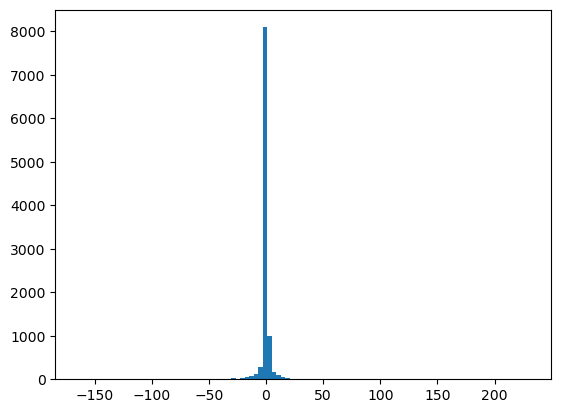

In [21]:
# df_melt_w.coefficients.plot.hist()
plt.hist(df_melt_w.coefficients, bins = 100)

In [23]:
np.var(df_melt_w.coefficients)

76.80496505582005

0.8128492484316544
0.7954939341421143
              precision    recall  f1-score   support

           0       0.96      0.79      0.86      1439
           1       0.44      0.84      0.58       292

    accuracy                           0.80      1731
   macro avg       0.70      0.81      0.72      1731
weighted avg       0.87      0.80      0.82      1731

0.39955242169815114
0.8128492484316544


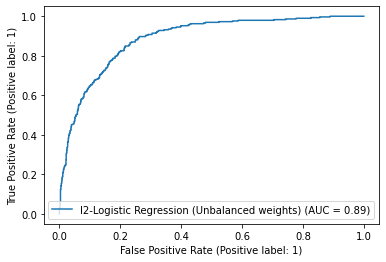

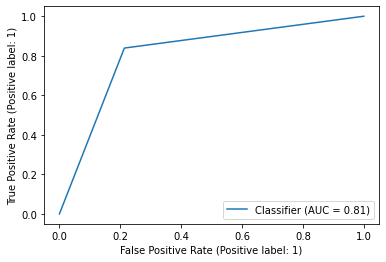

In [143]:
print(balanced_accuracy_score(y_test,y_pred_unbalanced))
print(metrics.accuracy_score(y_test,y_pred_unbalanced))
print(classification_report(y_test,y_pred_unbalanced))
print(metrics.average_precision_score(y_test, y_pred_unbalanced))

fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred_unbalanced)
print(metrics.auc(fpr, tpr))
ax = plt.gca()
RocCurveDisplay.from_estimator(logistic_cv_unbalanced, X_test, y_test,ax=ax,name="l2-Logistic Regression (Unbalanced weights)")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_pred_unbalanced)

In [140]:
np.mean(bal_accs)

0.7869890702166187

#### Unbalanced

In [59]:
print(np.mean(bal_accs))
print(np.mean(auc_scores))

0.6117478608461514
0.8394302064468324


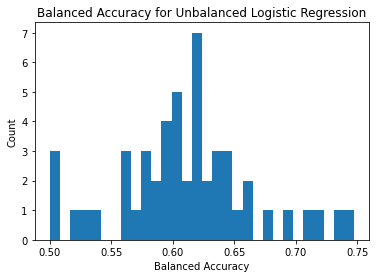

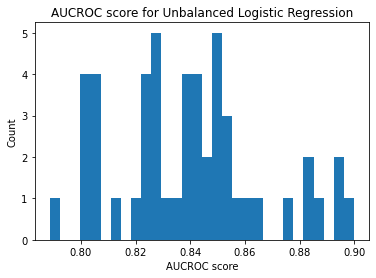

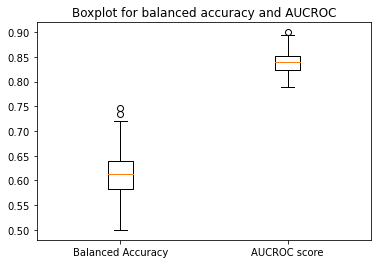

In [60]:
plt.hist(bal_accs, bins = 30)
plt.title('Balanced Accuracy for Unbalanced Logistic Regression')
plt.xlabel('Balanced Accuracy')
plt.ylabel('Count')
plt.show()

plt.hist(auc_scores, bins = 30)
plt.title('AUCROC score for Unbalanced Logistic Regression')
plt.xlabel('AUCROC score')
plt.ylabel('Count')
plt.show()


plt.boxplot([bal_accs, auc_scores])
plt.title('Boxplot for balanced accuracy and AUCROC')
plt.xticks([1, 2], ["Balanced Accuracy","AUCROC score"])
plt.show()

#### Balanced

In [61]:
print(np.mean(bal_accs_w))
print(np.mean(auc_scores_w))

0.7685108236575676
0.839012440108896


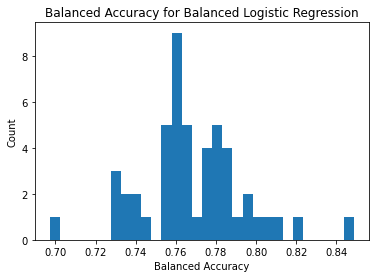

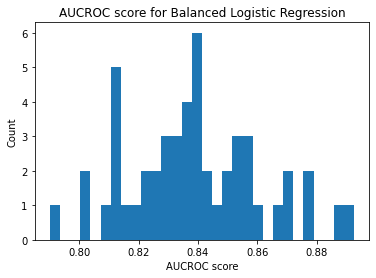

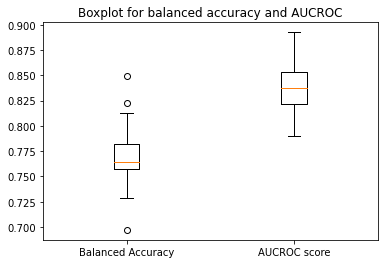

In [62]:
plt.hist(bal_accs_w, bins = 30)
plt.title('Balanced Accuracy for Balanced Logistic Regression')
plt.xlabel('Balanced Accuracy')
plt.ylabel('Count')
plt.show()

plt.hist(auc_scores_w, bins = 30)
plt.title('AUCROC score for Balanced Logistic Regression')
plt.xlabel('AUCROC score')
plt.ylabel('Count')
plt.show()


plt.boxplot([bal_accs_w, auc_scores_w])
plt.title('Boxplot for balanced accuracy and AUCROC')
plt.xticks([1, 2], ["Balanced Accuracy","AUCROC score"])
plt.show()

## pymc data with ridge regression

In [20]:
df = pd.read_csv('pymc_data.csv')
df_1 = df.iloc[:100, :5]
df_1['outcome'] = df.iloc[:100, -6]
df_2 = df.iloc[100:200, :5]
df_2['outcome'] = df.iloc[100:200, -6]
df_3 = df.iloc[200:300, :5]
df_3['outcome'] = df.iloc[200:300, -6]
df_4 = df.iloc[300:, :5]
df_4['outcome'] = df.iloc[300:, -6]
df_list = [df_1, df_2, df_3, df_4]

In [28]:
one_assay = df_list[0]
one_assay = one_assay.drop(one_assay.columns[0],axis=1)
scaler = StandardScaler().fit(one_assay.iloc[:,:4])
X = scaler.transform(one_assay.iloc[:,:4])
y = label_encoder.fit_transform(one_assay.iloc[:,4])
one_assay.iloc[:,4].value_counts()

0.0    50
1.0    50
Name: outcome, dtype: int64

0


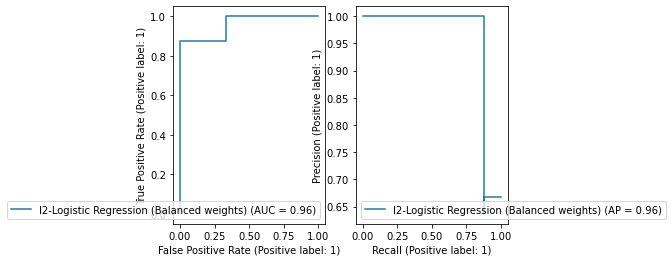

1


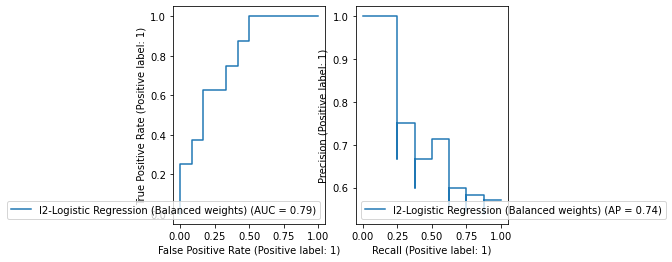

2


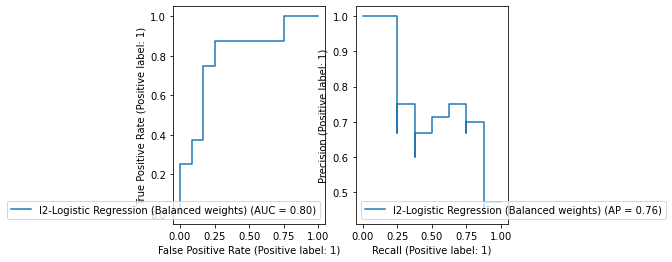

3


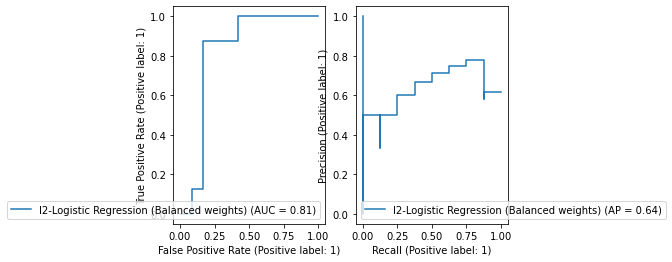

In [34]:
label_encoder = preprocessing.LabelEncoder()

coefs_w = []

bal_accs_w = []

auc_scores_w = []
lambdas_ridge = []
for i in range(len(df_list)):
    one_assay = df_list[i]
    one_assay = one_assay.drop(one_assay.columns[0],axis=1)
    scaler = StandardScaler().fit(one_assay.iloc[:,:4])
    X = scaler.transform(one_assay.iloc[:,:4])
    y = label_encoder.fit_transform(one_assay.iloc[:,4])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=42)
    logistic_cv_balanced = LogisticRegressionCV(penalty='l2',Cs=10,max_iter=10000,class_weight='balanced').fit(X_train, y_train)

    coef_w = logistic_cv_balanced.coef_[0]
    coefs_w.append(coef_w)

    y_pred_balanced = logistic_cv_balanced.predict(X_test)
    
    y_pred_prob_bal = logistic_cv_balanced.predict_proba(X_test)[:,1]

    print(i)
    
    bal_acc_w = balanced_accuracy_score(y_test,y_pred_balanced)
    bal_accs_w.append(bal_acc_w)
    
    auc_score_w = metrics.roc_auc_score(y_test, y_pred_prob_bal)
    auc_scores_w.append(auc_score_w)
    
    lambda_rid = logistic_cv_balanced.C_
    lambdas_ridge.append(lambda_rid)

    fig, (ax, ax1) = plt.subplots(1,2)

    RocCurveDisplay.from_estimator(logistic_cv_balanced, X_test, y_test,ax=ax,name="l2-Logistic Regression (Balanced weights)")

    PrecisionRecallDisplay.from_estimator(logistic_cv_balanced, X_test, y_test,ax=ax1,name="l2-Logistic Regression (Balanced weights)")

    plt.show()


In [30]:
print(np.mean(bal_accs_w))
print(np.mean(auc_scores_w))

0.78125
0.8411458333333334


In [32]:
np.sqrt(logistic_cv_balanced.C_)

array([1.66810054])

In [35]:
lambdas_ridge

[array([0.35938137]),
 array([0.00599484]),
 array([2.7825594]),
 array([2.7825594])]

In [28]:
pd.DataFrame(lambda_sig_w).to_csv('log_reg_w_lambda_sig.csv', index=False)

## Lasso - test for irrelevant features across all assays

In [26]:
import warnings
warnings.filterwarnings('ignore')
label_encoder = preprocessing.LabelEncoder()
coefs = []
coefs_w = []
bal_accs = []
bal_accs_w = []
auc_scores = []
auc_scores_w = []
lambda_sig_w = []

coef_df = []
coef_df_w = []

for i in range(len(df)):
    one_assay = df[i]
    one_assay = one_assay.drop(one_assay.columns[0],axis=1).drop_duplicates()
    scaler = StandardScaler().fit(one_assay.iloc[:,2:])
    X = scaler.transform(one_assay.iloc[:,2:])
    y = label_encoder.fit_transform(one_assay.iloc[:,0])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True)
    logistic_cv_unbalanced = LogisticRegressionCV(penalty='l1',class_weight=None, solver = 'saga').fit(X_train, y_train)
    logistic_cv_balanced = LogisticRegressionCV(penalty='l1',class_weight='balanced', solver = 'saga').fit(X_train, y_train)

    coef = logistic_cv_unbalanced.coef_[0]
    coef_u = pd.DataFrame({'features': list(one_assay.columns[2:]), 'coefs': list(coef)}, columns=['features', 'coefs'])
    coefs.append(coef)
    coef_df.append(coef_u)
    
    coef_w = logistic_cv_balanced.coef_[0]
    coef_w_df = pd.DataFrame({'features': list(one_assay.columns[2:]), 'coefs': list(coef_w)}, columns=['features', 'coefs'])
    coefs_w.append(coef_w)
    coef_df_w.append(coef_w_df)


    y_pred_unbalanced = logistic_cv_unbalanced.predict(X_test)
    y_pred_balanced = logistic_cv_balanced.predict(X_test)
    
    y_pred_prob = logistic_cv_unbalanced.predict_proba(X_test)[:,1]
    y_pred_prob_bal = logistic_cv_balanced.predict_proba(X_test)[:,1]

    print(one_assay.columns[0])
    print(classification_report(y_test,y_pred_balanced))
    
    bal_acc = balanced_accuracy_score(y_test,y_pred_unbalanced)
    bal_accs.append(bal_acc)
    
    bal_acc_w = balanced_accuracy_score(y_test,y_pred_balanced)
    bal_accs_w.append(bal_acc_w)
    
    auc_score = metrics.roc_auc_score(y_test, y_pred_prob)
    auc_scores.append(auc_score)
    
    auc_score_w = metrics.roc_auc_score(y_test, y_pred_prob_bal)
    auc_scores_w.append(auc_score_w)
    
    lambda_sig = logistic_cv_balanced.C_
    lambda_sig_w.append(lambda_sig)
    print(i)



tox21-ahr-p1
              precision    recall  f1-score   support

           0       0.98      0.80      0.88      1423
           1       0.24      0.77      0.37       120

    accuracy                           0.80      1543
   macro avg       0.61      0.78      0.62      1543
weighted avg       0.92      0.80      0.84      1543

0
tox21-ap1-agonist-p1
              precision    recall  f1-score   support

           0       0.98      0.82      0.89      1397
           1       0.18      0.67      0.28        84

    accuracy                           0.81      1481
   macro avg       0.58      0.74      0.59      1481
weighted avg       0.93      0.81      0.85      1481

1
tox21-ar-bla-antagonist-p1
              precision    recall  f1-score   support

           0       0.96      0.77      0.85      1371
           1       0.26      0.72      0.38       156

    accuracy                           0.76      1527
   macro avg       0.61      0.74      0.62      1527
weighted 

tox21-hdac-p1
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      1491
           1       0.12      0.70      0.21        27

    accuracy                           0.91      1518
   macro avg       0.56      0.81      0.58      1518
weighted avg       0.98      0.91      0.94      1518

24
tox21-hre-bla-agonist-p1
              precision    recall  f1-score   support

           0       0.96      0.78      0.86      1314
           1       0.21      0.62      0.32       128

    accuracy                           0.76      1442
   macro avg       0.58      0.70      0.59      1442
weighted avg       0.89      0.76      0.81      1442

25
tox21-hse-bla-p1
              precision    recall  f1-score   support

           0       0.98      0.83      0.90      1230
           1       0.21      0.72      0.33        78

    accuracy                           0.82      1308
   macro avg       0.59      0.77      0.61      1308
weighted avg

tox21-rt-viability-hepg2-p1
              precision    recall  f1-score   support

           0       0.97      0.75      0.85      1403
           1       0.14      0.67      0.23        85

    accuracy                           0.75      1488
   macro avg       0.56      0.71      0.54      1488
weighted avg       0.93      0.75      0.81      1488

48
tox21-rt-viability-hek293-p1
              precision    recall  f1-score   support

           0       0.94      0.78      0.85      1192
           1       0.42      0.77      0.54       243

    accuracy                           0.78      1435
   macro avg       0.68      0.78      0.70      1435
weighted avg       0.86      0.78      0.80      1435

49


In [53]:
fea_0 = []
fea_0_un = []
for i in range(len(coef_df_w)):
    co = list(coef_df_w[i][coef_df_w[i].coefs==0].features)
    co_un = list(coef_df[i][coef_df[i].coefs==0].features)
    if co != None:
        fea_0.append(co)
        fea_0_un.append(co_un)
    
len(fea_0)

50

204


(array([ 2.,  0., 43.,  0.,  0., 37.,  0., 30.,  0.,  0., 37.,  0., 23.,
         0.,  0., 28.,  0.,  2.,  0.,  2.]),
 array([ 3. ,  3.4,  3.8,  4.2,  4.6,  5. ,  5.4,  5.8,  6.2,  6.6,  7. ,
         7.4,  7.8,  8.2,  8.6,  9. ,  9.4,  9.8, 10.2, 10.6, 11. ]),
 <BarContainer object of 20 artists>)

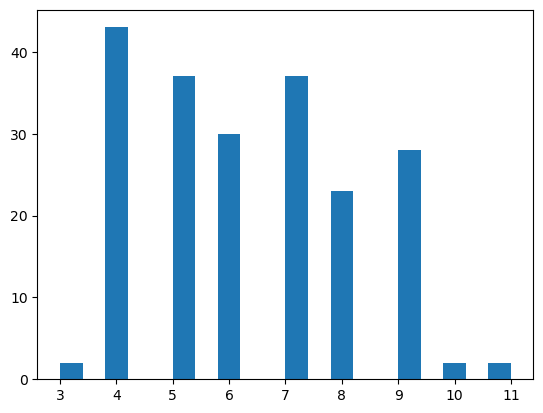

In [64]:
flat_list = [item for sublist in fea_0 for item in sublist]
flat_list = pd.DataFrame(flat_list, columns=['features'])
print(len(flat_list.features.value_counts()))
plt.hist(flat_list.features.value_counts(), bins=20)

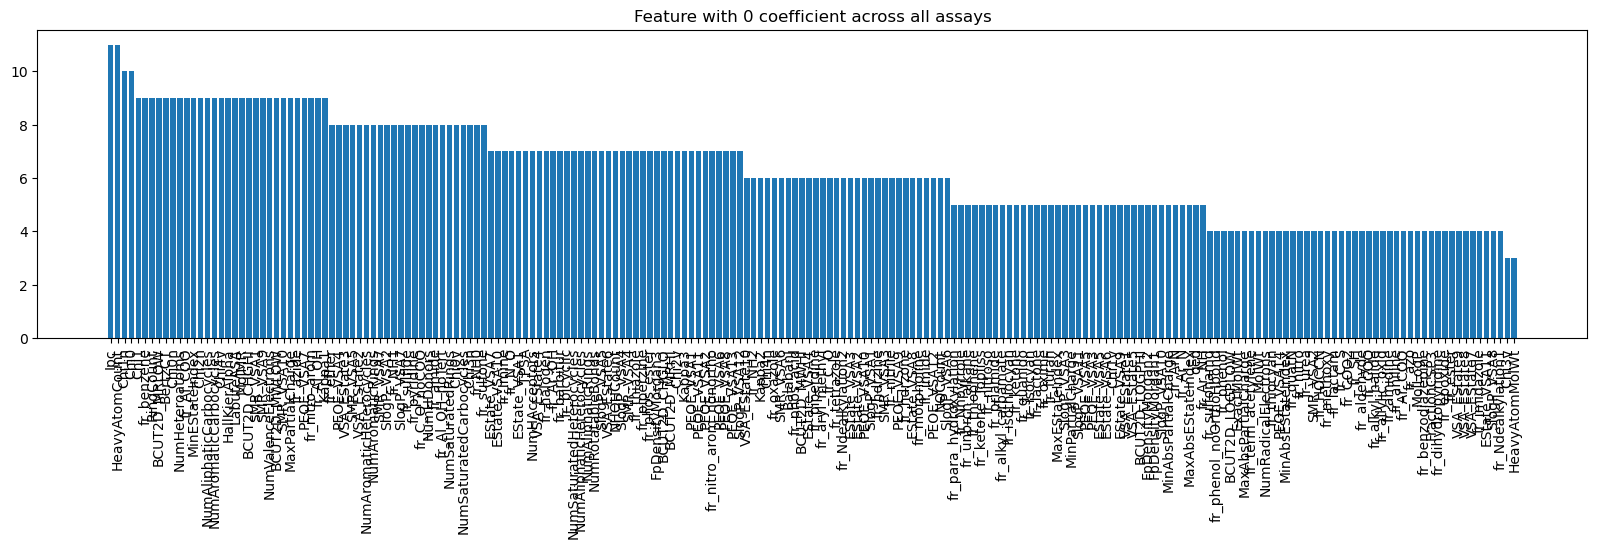

In [91]:
flat_list_un = [item for sublist in fea_0_un for item in sublist]
flat_list_un = pd.DataFrame(flat_list_un, columns=['features'])
feature_select = pd.DataFrame(flat_list.features.value_counts())
fig, ax = plt.subplots(figsize=(20,4))
plt.bar(feature_select.index, height = feature_select.features)
plt.xticks(rotation=90)
plt.title('Feature with 0 coefficient across all assays')
plt.savefig("feautes_with_0_coef.png",bbox_inches='tight')

In [86]:
feature_select[feature_select.features<=4]

features
fr_sulfonamd                   4
fr_phenol_noOrthoHbond         4
fr_phenol                      4
BCUT2D_LOGPLOW                 4
ExactMolWt                     4
MaxAbsPartialCharge            4
fr_term_acetylene              4
MolWt                          4
NumRadicalElectrons            4
fr_thiocyan                    4
PEOE_VSA14                     4
MinAbsEStateIndex              4
fr_quatN                       4
fr_nitro                       4
fr_urea                        4
SMR_VSA2                       4
fr_HOCCN                       4
fr_methoxy                     4
fr_lactam                      4
fr_C_S                         4
fr_COO2                        4
fr_SH                          4
fr_aldehyde                    4
fr_COO                         4
fr_alkyl_halide                4
fr_allylic_oxid                4
fr_amidine                     4
fr_aniline                     4
fr_Ar_COO                      4
fr_azo                         4
MolLogP                        4
fr_benzodiazepine              4
FractionCSP3                   4
fr_dihydropyridine             4
fr_epoxide                     4
fr_ester                       4
VSA_EState9                    4
VSA_EState8                    4
VSA_EState7                    4
fr_imidazole                   4
EState_VSA11                   4
SlogP_VSA8                     4
fr_Ndealkylation1              4
Chi3v                          3
HeavyAtomMolWt                 3